<a href="https://colab.research.google.com/github/armandossrecife/my_validation3/blob/main/my_analysis_hadoop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup do Ambiente de Análise

In [1]:
!rm -rf *.log
!rm -rf *.txt
!rm -rf *.xlsx
!rm -rf my_issues
!rm -rf hadoop

In [2]:
print('Install Pydriller.')
!pip install pydriller > install_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
print('Install Jira Python lib.')
!pip install jira > install_jira_python.log
print('Install SQLite in Linux')
!sudo apt install -y sqlite3 > install_sqlite.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')

Install Pydriller.
Install gitpython.
Install Jira Python lib.
Install SQLite in Linux


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
All depenpencies installed!
Details in install.log


## Importa bibliotecas necessárias

In [54]:
import os
from datetime import datetime, timedelta
import tqdm
from pydriller import Repository
from jira import JIRA
import pandas as pd
import re
import scipy.stats as stats
import random
import shutil
import time
from matplotlib import pyplot

## Variáveis Globais

In [41]:
my_repository = 'hadoop'
url_to_repository = 'https://github.com/apache/hadoop.git'
os.environ['MY_REPOSITORY'] = url_to_repository

JIRA_SERVER = 'https://issues.apache.org/jira'
ISSUE_TRACKER_PROJECT = 'HADOOP'

path_to_repository = 'hadoop'

# Credentials
os.environ['USERNAME'] = 'armandossrecife'
os.environ['PASSWORD'] = 'sky1979#ce'
username = os.environ.get('USERNAME')
password = os.environ.get('PASSWORD')

lista_arquivos_criticos = ['Configuration.java', 'Writable.java', 'StringUtils.java', 'FSDataOutputStream.java', 'BytesWritable.java', 'WritableComparable.java', 'DatanodeProtocol.java', 'ClientProtocol.java', 'FSNamesystem.java', 'DataNode.java','BlockManager.java', 'ResourceScheduler.java', 'ContainerManager.java', 'FairScheduler.java','CapacityScheduler.java', 'NodeManager.java', 'Job.java', 'Mapper.java', 'Reducer.java', 'InputFormat.java', 'OutputFormat.java']

## Clona o Repositório

In [5]:
print(f'Clona o repositório : {url_to_repository}')
!git clone $MY_REPOSITORY

Clona o repositório : https://github.com/apache/hadoop.git
Cloning into 'hadoop'...
remote: Enumerating objects: 4246877, done.
remote: Counting objects: 100% (78351/78351), done.
remote: Compressing objects: 100% (19635/19635), done.
remote: Total 4246877 (delta 66873), reused 68527 (delta 57478), pack-reused 4168526
Receiving objects: 100% (4246877/4246877), 2.16 GiB | 20.69 MiB/s, done.
Resolving deltas: 100% (3069814/3069814), done.
Updating files: 100% (15319/15319), done.


In [6]:
!cd hadoop && git log --pretty="%H %s" > all_commits_msg.txt
!cd hadoop && git log --pretty="%H;%ai;%s" > all_commits_full.txt

# Dados do 1o commit e do ultimo commit
!echo "Último commit: "
!head /content/hadoop/all_commits_full.txt -n 1
!echo "Primeiro commit: "
!tail /content/hadoop/all_commits_full.txt -n 1

Último commit: 
f1e4376626efb15d1c3001c0e50ab06536ce7057;2023-11-23 02:07:44 -0900;HADOOP-18959. Use builder for prefetch CachingBlockManager. (#6240) Contributed by Viraj Jasani
Primeiro commit: 
5128a9a453d64bfe1ed978cf9ffed27985eeef36;2009-05-19 04:20:40 +0000;HADOOP-4687 Moving src directories on branch


## Funções de apoio

In [35]:
def get_all_commits_by_range(initial_date, final_date, repository_name):
  """Extracts information from a date range of commits
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, commit's date, commit's line, commit's file, a list of files modified in the commit, a list of all diffs from modified files
  """
  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository(repository_name, since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository(repository_name, since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress commit anlysis"):
      list_of_modified_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_m_diff = {}
        if m is not None:
          list_of_modified_files.append(m.filename)
          dict_m_diff[m.filename] = m.diff
          list_dict_of_diff_modified_files.append(dict_m_diff)
      data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
      element = commit.msg, data_commit, commit.lines, commit.files, list_of_modified_files, list_dict_of_diff_modified_files
      dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

def get_commits_by_range_and_critical_files(initial_date, final_date, critical_files, repository_name):
  """Extracts information from a date range of commits, focusing on critical files.
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
      critical_files: A list of critical file paths. ex: ['StorageService.java', 'ColumnFamilyStore.java']
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, commits's date, commit's line, commit's file, a list of critical files modified in the commit, a list_of_modified_files, a dictionary of diff [filename]:filename.diff, a list of all diffs from modified files
        commit.msg, data_commit, commit.lines, commit.files, list_of_critical_files_modified, list_of_modified_files, list_dict_of_diff_files, list_dict_of_diff_modified_files
  """

  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository(repository_name, since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository(repository_name, since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress critical files commit anlysis"):
      list_of_critical_files_modified = []
      list_of_modified_files = []
      list_dict_of_diff_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_diff_file = {}
        list_of_modified_files.append(m.filename)
        list_dict_of_diff_modified_files.append(m.diff)
        if m.filename in critical_files:
          list_of_critical_files_modified.append(m.filename)
          dict_diff_file[m.filename] = m.diff
          list_dict_of_diff_files.append(dict_diff_file)
      if len(list_of_critical_files_modified) > 0:
        data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
        element = commit.msg, data_commit, commit.lines, commit.files, list_of_critical_files_modified, list_of_modified_files, list_dict_of_diff_files, list_dict_of_diff_modified_files
        dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

class JiraIssue:
  def __init__(self, key, summary, issue_type, status, priority, description, comments, created_date=None, updated_date=None, resolved_date=None):
    self.key = key
    self.summary = summary
    self.issue_type = issue_type
    self.status = status
    self.priority = priority
    self.description = description
    self.comments = comments
    self.created_date = created_date
    self.updated_date = updated_date
    self.resolved_date = resolved_date

  def get_comments(self):
    return self.comments

  def __str__(self):
    return (f'Key: {self.key}, Summary: {self.summary}, Type: {self.issue_type}, Status: {self.status}')

class JiraIssues:
  def __init__(self,project, issues):
    self.project = project
    self.issues = issues

  def add_issue(self, issue):
    self.issues.append(issue)

  def get_issues(self) -> list:
    return self.issues

  def update_issues(self, issues):
    self.issues = issues

  def __str__(self):
    str_issues = ""
    for issue in self.get_issues():
      str_issues = str_issues + str(issue)
      str_issues = str_issues + ', '
    str_issues = '[' + str_issues + ']'
    return (f'Project: {self.project}, Qdt of issues: {len(self.issues)}, Issues: {str_issues}')

# Classe de utilidades para manipular o servidor Jira
class JiraUtils:
  def __init__(self, project, jira_instance):
    self.project = project
    self.jira_jira_instance = jira_instance

  def generate_intervals_between_dates(self, date1: tuple, date2: tuple, distance=120) -> list:
    start_date = datetime(date1[0], date1[1], date1[2])
    end_date = datetime(date2[0], date2[1], date2[2])
    interval_days = distance
    # Initialize a list to store the intervals
    intervals = []
    # Initialize the current date as the start date
    current_date = start_date
    # Loop to generate intervals until the current date is less than or equal to the end date
    while current_date < end_date:
        interval = (current_date, current_date + timedelta(days=interval_days - 1))
        intervals.append(interval)
        current_date += timedelta(days=interval_days)
    return intervals

  def convert_interval_dates(self, dates: list) -> list:
    list_interval_dates = []
    for each in dates:
      date1 = each[0]
      # Convert the date to a string in the format "YYYY/MM/DD".
      str_date1 = date1.strftime("%Y/%m/%d")
      date2 = each[1]
      str_date2 = date2.strftime("%Y/%m/%d")
      elemento = str_date1, str_date2
      list_interval_dates.append(elemento)
    return list_interval_dates

  def generate_list_of_sentences(self, dates: list) -> list:
    lista_sentencas = []
    for each in dates:
      str_date1 = each[0].strftime("%Y/%m/%d")
      str_date2 = each[1].strftime("%Y/%m/%d")
      sentenca = f'project={self.project.upper()} and created>="{str_date1}" and created<="{str_date2}"'
      lista_sentencas.append(sentenca)
    return lista_sentencas

  def get_list_of_block_issues_by_dates(self,date1, date2, distance=120) -> list:
    print('Aguarde...')
    t1 = datetime.now()
    list_of_dates = self.generate_intervals_between_dates(date1,date2,distance)
    lista_sentencas = self.generate_list_of_sentences(list_of_dates)
    lista_bloco_issues_by_date = []
    total_items = len(lista_sentencas)
    i = 0
    iterable_lista_sentencas = tqdm.tqdm(lista_sentencas, total=total_items)
    for each in iterable_lista_sentencas:
      issues_by_date_temp = self.jira_jira_instance.search_issues(each,maxResults=1000)
      print(f'Range: {each}, qtd issues: {len(issues_by_date_temp)}')
      lista_bloco_issues_by_date.append(issues_by_date_temp)
      percentage = (i + 1) / total_items * 100
      iterable_lista_sentencas.set_description(f"Progress Message Analysis")
    i += 1
    t2 = datetime.now()
    print(t2)
    print(f'Tempo da consulta: {t2-t1}')
    return lista_bloco_issues_by_date

  def concatenate_block_of_issues(self,block_of_issues):
    concatenated_list = [item for sublist in block_of_issues for item in sublist]
    print(f'Total de issues recuperados: {len(concatenated_list)}')
    return concatenated_list

def analyze_jira_all_issues(project, all_issues):
    """Extracts all issues from Issue Tracker
        Args:
          project: Issue Tracker Project name, example: CASSANDRA
          all_issues: a block of issues
        Returns:
          A list of JiraIssues
    """
    # Create an instance of JiraIssues to manage all issues
    my_all_issues = JiraIssues(project, [])
    total_items = len(all_issues)

    # Iterate through the fetched issues
    for issue in tqdm.tqdm(all_issues, total=total_items, desc='Progress jira all issues analysis'):
        issue_key = issue.key
        issue_summary = issue.fields.summary
        issue_description = issue.fields.description
        issue_comments = [comment.body for comment in issue.fields.comment.comments]
        issue_created_date = issue.fields.created
        issue_updated_date = None
        issue_resolved_date = issue.fields.resolutiondate

        # Check for SATD keywords in the issue's summary, description, and comments
        if issue_summary is None:
            issue_summary = ""
        if issue_description is None:
            issue_description = ""
        if issue_comments is None:
            issue_comments = ""
        if issue_created_date == None:
            issue_created_date = ""
        if issue_updated_date == None:
            issue_updated_date = ""
        if issue_resolved_date == None:
            issue_resolved_date = ""

        issue_type = issue.fields.issuetype.name
        issue_status = issue.fields.status.name
        issue_priority = issue.fields.priority.name

        # Create a JiraIssue instance for the SATD issue
        my_issue = JiraIssue(issue_key, issue_summary, issue_type, issue_status, issue_priority, issue_description, issue_comments, issue_created_date, issue_updated_date, issue_resolved_date)

        my_all_issues.add_issue(my_issue)

    return my_all_issues

def convert_date_jira_to_datetime(jira_date):
  regex = r"(\d{4})-(\d{2})-(\d{2})"
  match = re.match(regex, jira_date)

  if match:
      year, month, day = match.groups()
      datetime_object = datetime(year=int(year), month=int(month), day=int(day))
      return datetime_object
  else:
      return None

def convert_issues_to_dataframe(all_real_issues):
  l_issue_key_aux, l_issue_type_aux, l_issue_summary_aux, l_issue_description_aux, l_issue_status_aux, l_issue_priority_aux, l_issue_comments_aux = [], [], [], [], [], [], []
  l_issue_created_date, l_issue_resolved_date = [], []

  for issue in all_real_issues.get_issues():
    l_issue_key_aux.append(issue.key)
    l_issue_type_aux.append(issue.issue_type)
    l_issue_summary_aux.append(issue.summary)
    l_issue_description_aux.append(issue.description)
    l_issue_status_aux.append(issue.status)
    l_issue_priority_aux.append(issue.priority)
    texto_aux = ""
    for item in issue.get_comments():
      texto_aux = texto_aux + str(item) + "\n"
    l_issue_comments_aux.append(texto_aux)
    created_date_temp = convert_date_jira_to_datetime(issue.created_date)
    l_issue_created_date.append(created_date_temp)
    resolved_date_temp = convert_date_jira_to_datetime(issue.resolved_date)
    l_issue_resolved_date.append(resolved_date_temp)

  dict_all_reall_issues_in_commits_detailed = {
  'issue_key': l_issue_key_aux,
  'issue_type':l_issue_type_aux,
  'status':l_issue_status_aux,
  'priority':l_issue_priority_aux,
  'summary':l_issue_summary_aux,
  'description':l_issue_description_aux,
  'comments':l_issue_comments_aux,
  'created_date': l_issue_created_date,
  'resolved_date': l_issue_resolved_date
  }

  df_all_reall_issues_in_commits_detailed = pd.DataFrame(dict_all_reall_issues_in_commits_detailed)
  return df_all_reall_issues_in_commits_detailed

def convert_commits_to_dataframe(dict_of_commits):
  '''
  v[0] = commit.msg,
  v[1] = data_commit,
  v[2] = commit.lines,
  v[3] = commit.files,
  v[4] = list_of_critical_files_modified,
  v[5] = list_of_modified_files,
  v[6] = list_dict_of_diff_files,
  v[7] = list_dict_of_diff_modified_files
  '''
  l_commit_hash, l_commit_msg, l_commit_data, l_commit_lines, l_commit_files, l_commit_critical_files, l_commit_modified_fies, l_commit_diff_files, l_commit_diff_modified_files = [], [], [], [], [], [], [], [], []
  for k, v in dict_of_commits.items():
    l_commit_hash.append(k)
    if v[0] is not None:
      l_commit_msg.append(v[0])
    if v[1] is not None:
      l_commit_data.append(v[1])
    if v[2] is not None:
      l_commit_lines.append(v[2])
    if v[3] is not None:
      l_commit_files.append(v[3])
    if v[4] is not None:
      l_commit_critical_files.append(v[4])
    if v[5] is not None:
      l_commit_modified_fies.append(v[5])
    if v[6] is not None:
      l_commit_diff_files.append(v[6])
    if v[7] is not None:
      l_commit_diff_modified_files.append(v[7])

  dict_of_commits_aux = {
      'hash': l_commit_hash,
      'msg': l_commit_msg,
      'date': l_commit_data,
      'lines': l_commit_lines,
      'files': l_commit_files,
      'critical_files': l_commit_critical_files,
      'modified_files': l_commit_modified_fies,
      'diff_files': l_commit_diff_files,
      'diff_files_modified_files': l_commit_diff_modified_files
  }

  df_commits = pd.DataFrame(dict_of_commits_aux)
  return df_commits

def convert_commits_to_dataframe2(dict_of_commits):
  '''
  v[0] = commit.msg,
  v[1] = data_commit,
  v[2] = commit.lines,
  v[3] = commit.files,
  v[4] = list_of_files_modified,
  v[5] = list_of_diff_modified_files,
  '''
  l_commit_hash, l_commit_msg, l_commit_data, l_commit_lines, l_commit_files, l_commit_modified_files, l_commit_diff_modified_fies = [], [], [], [], [], [], []
  for k, v in dict_of_commits.items():
    l_commit_hash.append(k)
    if v[0] is not None:
      l_commit_msg.append(v[0])
    if v[1] is not None:
      l_commit_data.append(v[1])
    if v[2] is not None:
      l_commit_lines.append(v[2])
    if v[3] is not None:
      l_commit_files.append(v[3])
    if v[4] is not None:
      l_commit_modified_files.append(v[4])
    if v[5] is not None:
      l_commit_diff_modified_fies.append(v[5])

  dict_of_commits_aux = {
      'hash': l_commit_hash,
      'msg': l_commit_msg,
      'date': l_commit_data,
      'lines': l_commit_lines,
      'files': l_commit_files,
      'modified_files': l_commit_modified_files,
      'diff_modified_files': l_commit_diff_modified_fies,
  }

  df_commits = pd.DataFrame(dict_of_commits_aux)
  return df_commits


def find_issues_id_by_project(input_string: str, project: str) -> list[str]:
    """Finds all Cassandra issue ID patterns in the input string.
    Args:
        input_string: The input string.
        project: The pattern related to project name, for example: CASSANDRA project name
    Returns:
        A list of project issue IDs, if found; otherwise, an empty list.
    """
    # Try to find all Cassandra issue ID patterns in the input string
    matches = re.findall(r"({0}-\d+)".format(project), input_string)
    # Return an empty list if no matches are found
    if not matches:
        return []
    # Convert the list of matches to a set to remove duplicates
    set_matches = set(matches)
    # Convert the set of matches back to a list
    list_unique_matches = list(set_matches)

    # Return the list of matched Cassandra issue IDs
    return list_unique_matches

def get_commits_with_critical_files_and_issues_in_this_commits(df_commits_with_critical_files):
  dict_issues_in_commits = {}
  for index in df_commits_with_critical_files.index:
    l_issues_in_commit = find_issues_id_by_project(input_string=df_commits_with_critical_files.msg[index], project=ISSUE_TRACKER_PROJECT)
    if len(l_issues_in_commit) > 0:
      commit_hash = df_commits_with_critical_files.hash[index]
      dict_issues_in_commits[commit_hash] = l_issues_in_commit

  list_issue_commits, list_issue_issues = [], []
  for k, v in dict_issues_in_commits.items():
    list_issue_commits.append(k)
    for issue in v:
      if issue not in list_issue_issues:
        list_issue_issues.append(issue)

  df_aux  = df_all_reall_issues_in_commits_detailed.copy()
  df_issues_in_commits_with_critical_classes = df_aux[df_aux['issue_key'].isin(list_issue_issues)]

  return dict_issues_in_commits, df_issues_in_commits_with_critical_classes

def calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size):
    # Calculate the Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the sample size formula
    sample_size = ((z_score**2) * population_proportion * (1 - population_proportion)) / (margin_of_error**2)

    # Adjust for finite population
    if population_size:
        sample_size = sample_size / (1 + ((sample_size - 1) / population_size))

    return int(sample_size)

def get_max_n_chars(text, max_n):
  text_length = len(text)
  if text_length <= max_n:
    return text
  else:
    return text[:max_n]

def create_new_file(filename, dir_name, issue_type, summary, description, status, comments):
  try:
    filename = dir_name + '/' + filename

    if issue_type is None:
      issue_type = ''
    if summary is None:
      summary = ''
    if description is None:
      description = ''
    if status is None:
      status = ''
    if comments is None:
      comments = ''

    with open(filename, mode='w') as f_issue:
      f_issue.write(f'issue_type: {issue_type} \n')
      f_issue.write(f'summary: {summary} \n')
      f_issue.write(f'description: {get_max_n_chars(text=description, max_n=1000)} \n')
      f_issue.write(f'status: {status} \n')
      f_issue.write(f'comments: {get_max_n_chars(text=comments, max_n=4000)} \n')
    print(f'File {filename} created with success!')

  except Exception as ex:
    print(f'Erro ao criar arquivo: {str(ex)}')

# Seleciona randomicamente os issues para inspeção
def select_issues_to_inspection(sample_size, df_issues_in_commits_with_critical_classes, my_date='02/11/2023'):
  lista_issues_inspecao = []
  dict_issues_para_inspecao = {}
  list_issue_key = df_issues_in_commits_with_critical_classes.issue_key.to_list()
  list_issue_key = list(set(list_issue_key))
  sample_issues = random.choices(list_issue_key, k=sample_size)
  dict_issues_para_inspecao['02/11/2023'] = sample_issues
  print(f'{len(sample_issues)} para inspeção manual')

  date_file_name = my_date.split('/')
  date_file_name = date_file_name[0] + date_file_name[1] + date_file_name[2]
  file_name = 'issues_inspecao_' + date_file_name + '.txt'
  with open(file_name, mode='w') as f_temp:
    for v in dict_issues_para_inspecao[my_date]:
      elemento = v + ','
      f_temp.write(elemento)
  print(f'Relação de Issues salvos em {my_date} para inspeção.')
  return sample_issues

# Gera os arquivos .txt de cada issue selecionado para inspeção
def generate_files_issues_to_inspection(sample_issues, df_issues_in_commits_with_critical_classes):
  contador = 0
  my_dir_name = 'my_issues'
  if not os.path.exists(my_dir_name):
    os.makedirs(my_dir_name)

  total_of_issues = df_issues_in_commits_with_critical_classes.shape[0]
  for index in tqdm.tqdm(df_issues_in_commits_with_critical_classes.index, total=total_of_issues, desc='Analyzing issues'):
    for issue in sample_issues:
      if df_issues_in_commits_with_critical_classes.issue_key[index] == issue:
        create_new_file(filename=df_issues_in_commits_with_critical_classes.issue_key[index], dir_name=my_dir_name, issue_type=df_issues_in_commits_with_critical_classes.issue_type[index], summary=df_issues_in_commits_with_critical_classes.summary[index], description=df_issues_in_commits_with_critical_classes.description[index], status=df_issues_in_commits_with_critical_classes.status[index], comments=df_issues_in_commits_with_critical_classes.comments[index])
        contador += 1
  print(f'Foram criados {contador} arquivos para inspeção')

class SATDCommitAnalyzer:
    def __init__(self, path_to_repository):
        self.path_to_repository = path_to_repository

    @staticmethod
    def is_java_comment(line):
        """Checks if a line is a single-line Java comment.
        Args:
          line: The line to check.
        Returns:
          True if the line is a single-line Java comment, False otherwise.
        """
        # Regular expression pattern to match Java comments
        comment_pattern = r'^\s*//|^\s*/\*|^\s*\*|^\s*\*/'
        # Use the re.match function to check if the line matches the comment pattern
        return bool(re.match(comment_pattern, line))

    def analyze_commits_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for SATD by checking if the commit message contains any of the specified SATD keywords.
        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.
        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD message commit analysis"):
            for keyword in satd_keywords:
                if keyword in commit.msg:
                    commits_with_satd.add(commit.hash)
                    dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commits_for_no_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for NO SATD by checking if the commit message does contain any of the specified SATD keywords.
        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.
        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD message commit analysis"):
          if self.testa_keywords_not_in_text(list(satd_keywords), commit.msg) is not None:
            commits_with_satd.add(commit.hash)
            dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commit_diffs_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.
        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.
        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD diff commit analysis"):
            list_keywords_by_commit = []
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]

                    for keyword in satd_keywords:
                        if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                            if keyword in conteudo_linha:
                                list_keywords_by_commit.append(keyword)
                                list_diff_content_by_commit.append(conteudo_linha)

            if list_keywords_by_commit:
                elemento = commit.msg, commit.lines, commit.files, list_keywords_by_commit, list_diff_content_by_commit
                dict_commit_diffs[commit.hash] = elemento

        return dict_commit_diffs

    def analyze_commit_diffs_for_no_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for NO SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.
        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.
        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD diff commit analysis"):
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]
                    if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                        if self.testa_keywords_not_in_text(list(satd_keywords), conteudo_linha) is not None:
                            list_diff_content_by_commit.append(conteudo_linha)
            dict_commit_diffs[commit.hash] = commit.msg, commit.lines, commit.files,list_diff_content_by_commit
        return dict_commit_diffs

    def total_of_commits(self, start_date, end_date):
        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))
        lista_hash_commits = []
        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress messagem commit analysis"):
            lista_hash_commits.append(commit.hash)
        return total_commits, lista_hash_commits

    def testa_keywords_not_in_text(self,keywords, my_text):
      qtd_itens = len(keywords)
      lista_checa = []
      for i, each in enumerate(keywords):
        if keywords[i] not in my_text:
          lista_checa.append(0)
      if len(lista_checa)==qtd_itens and sum(lista_checa) == 0:
        return my_text
      return None

def create_df_commits_diffs_satd(dict_commit_diffs_satd):
  l_commits, l_msgs, l_lines, l_files, l_keywords, l_comments = [], [], [], [], [], []

  for k, v in dict_commit_diffs_satd.items():
    l_commits.append(k)
    l_msgs.append(v[0])
    l_lines.append(v[1])
    l_files.append(v[2])
    l_keywords.append(v[3])
    l_comments.append(v[4])

  dict_commit_diffs_satd_aux = {
      'commit': l_commits,
      'msg': l_msgs,
      'lines': l_lines,
      'files': l_files,
      'keywords': l_keywords,
      'comments': l_comments
  }

  df_commit_diffs_aux = pd.DataFrame(dict_commit_diffs_satd_aux)
  return df_commit_diffs_aux

def create_df_commits_diffs_no_satd(dict_commit_diffs_no_satd):
  l_commits_no_satd, l_msg_no_satd, l_lines_no_satd, l_files_no_satd, l_comments_no_satd = [], [], [], [], []

  for k, v in dict_commit_diffs_no_satd.items():
    if len(v[3]) > 0:
      l_commits_no_satd.append(k)
      l_msg_no_satd.append(v[0])
      l_lines_no_satd.append(v[1])
      l_files_no_satd.append(v[2])
      l_comments_no_satd.append(v[3])

  dict_commit_diffs_aux_no_satd = {
      'commits': l_commits_no_satd,
      'msg': l_msg_no_satd,
      'lines': l_lines_no_satd,
      'files': l_files_no_satd,
      'comments': l_comments_no_satd
  }

  df_commit_diffs_aux_no_satd = pd.DataFrame(dict_commit_diffs_aux_no_satd)

  return df_commit_diffs_aux_no_satd

# 1. Extrai commits de um repositório de código

In [13]:
start_date = datetime(2009, 5, 19, 0, 0, 0)
end_date = datetime(2023, 10, 4, 0, 0, 0)
extract_all_commits = get_all_commits_by_range(initial_date=start_date, final_date=end_date, repository_name=my_repository)

all_commits = extract_all_commits[0]
total_all_commits = extract_all_commits[1]

print(f'Total de commits extraídos: {total_all_commits}')

Wait...


Progress commit anlysis: 100%|██████████| 26906/26906 [22:38<00:00, 19.81it/s]

Total de commits extraídos: 26906


## Filtra os commits com classes críticas

In [14]:
print(f'Analisa a faixa de commits entre: initial_date={str(start_date)}, final_date={str(end_date)}')
print('Registra apenas os commits que contem pelo menos um arquivo crítico')
filter_commits_with_critical_files = get_commits_by_range_and_critical_files(initial_date=start_date, final_date=end_date, critical_files=lista_arquivos_criticos, repository_name=my_repository)
commits_with_critical_files = filter_commits_with_critical_files[0]
total_of_commits_with_critical_files = filter_commits_with_critical_files[1]

print(f'Total de commits com classes críticas: {total_of_commits_with_critical_files}')

Analisa a faixa de commits entre: initial_date=2009-05-19 00:00:00, final_date=2023-10-04 00:00:00
Registra apenas os commits que contem pelo menos um arquivo crítico
Wait...


Progress critical files commit anlysis: 100%|██████████| 26906/26906 [12:51<00:00, 34.90it/s]

Total de commits com classes críticas: 26906


### Converte os commits com classes críticas para dataframe

In [15]:
df_commits_with_critical_files = convert_commits_to_dataframe(dict_of_commits=commits_with_critical_files)
df_commits_with_critical_files

,hash,msg,date,lines,files,critical_files,modified_files,diff_files,diff_files_modified_files
0,5128a9a453d64bfe1ed978cf9ffed27985eeef36,HADOOP-4687 Moving src directories on branch\n...,19/5/2009,67543,352,"[Configuration.java, FSDataOutputStream.java, ...","[core-default.xml, HadoopVersionAnnotation.jav...","[{'Configuration.java': '@@ -0,0 +1,1326 @@ +/...","[@@ -0,0 +1,444 @@\n+<?xml version=""1.0""?>\n+<..."
1,bcd64325a11cb0dd5096ffc093d0ffa68c4fcc58,"Merged src/core, src/test/core, src/contrib/ec...",15/6/2009,1799,37,[StringUtils.java],"[hadoop-ec2-init-remote.sh, launch-hadoop-slav...","[{'StringUtils.java': '@@ -88,7 +88,8 @@ publi...","[@@ -17,7 +17,9 @@ MASTER_HOST=%MASTER_HOST% #..."
2,b12d765467fd9a4447c473d613d92883fb09c76b,HADOOP-4687. Merge -r 784663:785643 from trunk...,17/6/2009,73,4,[StringUtils.java],"[CHANGES.txt, LocalDirAllocator.java, StringUt...","[{'StringUtils.java': '@@ -677,4 +677,24 @@ pu...","[@@ -68,6 +68,9 @@ Trunk (unreleased changes)\..."
3,a13237975d02b3db913b95845d4b8d6d22f2bac7,HADOOP-2366. Support trimmed strings in Config...,30/6/2009,98,4,"[Configuration.java, StringUtils.java]","[CHANGES.txt, Configuration.java, StringUtils....","[{'Configuration.java': '@@ -31,6 +31,7 @@ im...","[@@ -468,6 +468,9 @@ Trunk (unreleased changes..."
4,3200b2ec588dfa5c50f1ec6192ff93ab9187f82d,HADOOP-6161. Add get/setEnum methods to Config...,20/7/2009,43,3,[Configuration.java],"[CHANGES.txt, Configuration.java, TestConfigur...","[{'Configuration.java': '@@ -595,6 +595,30 @@ ...","[@@ -480,6 +480,8 @@ Trunk (unreleased changes..."
...,...,...,...,...,...,...,...,...,...
2771,d5334fa76170b99f1ddd6b307482d226da12f1a9,YARN-6537. Running RM tests against the Router...,3/9/2023,816,12,[NodeManager.java],"[YarnConfiguration.java, NodeManager.java, pom...","[{'NodeManager.java': '@@ -1074,4 +1074,9 @@ p...","[@@ -517,7 +517,7 @@ public static boolean isA..."
2772,4652d22b9195d35eac4d7e02d1f99ebc6a5835c7,HDFS-17178: BootstrapStandby needs to handle R...,12/9/2023,256,11,[FSNamesystem.java],"[pom.xml, PBHelper.java, HdfsServerConstants.j...","[{'FSNamesystem.java': '@@ -1898,9 +1898,7 @@ ...","[@@ -219,6 +219,10 @@ https://maven.apache.org..."
2773,ecee022e49269bd6612d32695c6b46a95c6bf11e,HDFS-17197. Show file replication when listing...,25/9/2023,25,1,[FSNamesystem.java],[FSNamesystem.java],"[{'FSNamesystem.java': '@@ -6131,15 +6131,20 @...","[@@ -6131,15 +6131,20 @@ void releaseBackupNod..."
2774,26a5f38250de1ac4978427d74c200a968f9a0b65,HDFS-17204. EC: Reduce unnecessary log when pr...,26/9/2023,6,1,[BlockManager.java],[BlockManager.java],"[{'BlockManager.java': '@@ -4201,6 +4201,12 @@...","[@@ -4201,6 +4201,12 @@ private void chooseExc..."


In [16]:
df_commits_with_critical_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   hash                       2776 non-null   object
 1   msg                        2776 non-null   object
 2   date                       2776 non-null   object
 3   lines                      2776 non-null   int64 
 4   files                      2776 non-null   int64 
 5   critical_files             2776 non-null   object
 6   modified_files             2776 non-null   object
 7   diff_files                 2776 non-null   object
 8   diff_files_modified_files  2776 non-null   object
dtypes: int64(2), object(7)
memory usage: 195.3+ KB


In [17]:
df_commits_with_critical_files.to_excel('hadoop_commits_with_critical_classes.xlsx', index=False)

### Lista todos os commits extraídos

In [36]:
list_all_commits_hash = []
for k, v in all_commits.items():
  list_all_commits_hash.append(k)

print(len(list_all_commits_hash))

26906


### Lista apenas os hash commits com classes críticas

In [37]:
list_only_commits_critical_classes = df_commits_with_critical_files.hash.to_list()
print(len(list_only_commits_critical_classes))

2776


### Lista os commits sem classes críticas

In [38]:
list_commits_no_critical_classes = []
set_all_commits_hash =  set(list_all_commits_hash)
set_only_commits_critical_classes = set(list_only_commits_critical_classes)

set_commits_no_critical_classes = set_all_commits_hash.difference(set_only_commits_critical_classes)
list_commits_no_critical_classes = list(set_commits_no_critical_classes)

print(len(list_commits_no_critical_classes))

24130


# 2. Extrai issues de um issue tracker

## Configura ambiente para acessar Issue Tracker

In [18]:
# Initialize the Jira connection
print('Initialize the Jira connection')
jira = JIRA(JIRA_SERVER, basic_auth=(username, password))

# Create a JiraUtils instance
print('Create a JiraUtils instance')
jira_utils = JiraUtils(ISSUE_TRACKER_PROJECT, jira)

date1 = (2009, 5, 19)
date2 = (2023, 10, 4)
distance = 120
print('Define date intervals')
print(f'From: {str(date1)} to: {date2}, by: {distance} days of distance.')

Initialize the Jira connection
Create a JiraUtils instance
Define date intervals
From: (2009, 5, 19) to: (2023, 10, 4), by: 120 days of distance.


## Recupera os issues do período dado

In [19]:
# Fetch issues using date intervals
print('Fetch issues using date intervals')
block_of_issues = jira_utils.get_list_of_block_issues_by_dates(date1, date2, distance)

Fetch issues using date intervals
Aguarde...


Progress Message Analysis:   2%|▏         | 1/44 [00:03<02:21,  3.28s/it]

Range: project=HADOOP and created>="2009/05/19" and created<="2009/09/15", qtd issues: 244


Progress Message Analysis:   5%|▍         | 2/44 [00:05<01:55,  2.75s/it]

Range: project=HADOOP and created>="2009/09/16" and created<="2010/01/13", qtd issues: 211


Progress Message Analysis:   7%|▋         | 3/44 [00:09<02:04,  3.04s/it]

Range: project=HADOOP and created>="2010/01/14" and created<="2010/05/13", qtd issues: 262


Progress Message Analysis:   9%|▉         | 4/44 [00:11<01:56,  2.92s/it]

Range: project=HADOOP and created>="2010/05/14" and created<="2010/09/10", qtd issues: 177


Progress Message Analysis:  11%|█▏        | 5/44 [00:13<01:36,  2.47s/it]

Range: project=HADOOP and created>="2010/09/11" and created<="2011/01/08", qtd issues: 133


Progress Message Analysis:  14%|█▎        | 6/44 [00:15<01:30,  2.38s/it]

Range: project=HADOOP and created>="2011/01/09" and created<="2011/05/08", qtd issues: 169


Progress Message Analysis:  16%|█▌        | 7/44 [00:19<01:50,  3.00s/it]

Range: project=HADOOP and created>="2011/05/09" and created<="2011/09/05", qtd issues: 333


Progress Message Analysis:  18%|█▊        | 8/44 [00:24<02:02,  3.41s/it]

Range: project=HADOOP and created>="2011/09/06" and created<="2012/01/03", qtd issues: 327


Progress Message Analysis:  20%|██        | 9/44 [00:29<02:17,  3.92s/it]

Range: project=HADOOP and created>="2012/01/04" and created<="2012/05/02", qtd issues: 374


Progress Message Analysis:  23%|██▎       | 10/44 [00:33<02:19,  4.10s/it]

Range: project=HADOOP and created>="2012/05/03" and created<="2012/08/30", qtd issues: 377


Progress Message Analysis:  25%|██▌       | 11/44 [00:39<02:34,  4.69s/it]

Range: project=HADOOP and created>="2012/08/31" and created<="2012/12/28", qtd issues: 382


Progress Message Analysis:  27%|██▋       | 12/44 [00:43<02:23,  4.48s/it]

Range: project=HADOOP and created>="2012/12/29" and created<="2013/04/27", qtd issues: 328


Progress Message Analysis:  30%|██▉       | 13/44 [00:48<02:17,  4.44s/it]

Range: project=HADOOP and created>="2013/04/28" and created<="2013/08/25", qtd issues: 361


Progress Message Analysis:  32%|███▏      | 14/44 [00:52<02:08,  4.30s/it]

Range: project=HADOOP and created>="2013/08/26" and created<="2013/12/23", qtd issues: 268


Progress Message Analysis:  34%|███▍      | 15/44 [00:57<02:10,  4.51s/it]

Range: project=HADOOP and created>="2013/12/24" and created<="2014/04/22", qtd issues: 324


Progress Message Analysis:  36%|███▋      | 16/44 [01:02<02:12,  4.72s/it]

Range: project=HADOOP and created>="2014/04/23" and created<="2014/08/20", qtd issues: 427


Progress Message Analysis:  39%|███▊      | 17/44 [01:07<02:11,  4.86s/it]

Range: project=HADOOP and created>="2014/08/21" and created<="2014/12/18", qtd issues: 416


Progress Message Analysis:  41%|████      | 18/44 [01:12<02:07,  4.89s/it]

Range: project=HADOOP and created>="2014/12/19" and created<="2015/04/17", qtd issues: 381


Progress Message Analysis:  43%|████▎     | 19/44 [01:20<02:24,  5.76s/it]

Range: project=HADOOP and created>="2015/04/18" and created<="2015/08/15", qtd issues: 429


Progress Message Analysis:  45%|████▌     | 20/44 [01:24<02:03,  5.16s/it]

Range: project=HADOOP and created>="2015/08/16" and created<="2015/12/13", qtd issues: 268


Progress Message Analysis:  48%|████▊     | 21/44 [01:28<01:56,  5.05s/it]

Range: project=HADOOP and created>="2015/12/14" and created<="2016/04/11", qtd issues: 360


Progress Message Analysis:  50%|█████     | 22/44 [01:34<01:56,  5.31s/it]

Range: project=HADOOP and created>="2016/04/12" and created<="2016/08/09", qtd issues: 445


Progress Message Analysis:  52%|█████▏    | 23/44 [01:41<01:57,  5.61s/it]

Range: project=HADOOP and created>="2016/08/10" and created<="2016/12/07", qtd issues: 381


Progress Message Analysis:  55%|█████▍    | 24/44 [01:46<01:52,  5.64s/it]

Range: project=HADOOP and created>="2016/12/08" and created<="2017/04/06", qtd issues: 398


Progress Message Analysis:  57%|█████▋    | 25/44 [01:52<01:45,  5.56s/it]

Range: project=HADOOP and created>="2017/04/07" and created<="2017/08/04", qtd issues: 434


Progress Message Analysis:  59%|█████▉    | 26/44 [01:56<01:32,  5.13s/it]

Range: project=HADOOP and created>="2017/08/05" and created<="2017/12/02", qtd issues: 334


Progress Message Analysis:  61%|██████▏   | 27/44 [02:00<01:20,  4.73s/it]

Range: project=HADOOP and created>="2017/12/03" and created<="2018/04/01", qtd issues: 259


Progress Message Analysis:  64%|██████▎   | 28/44 [02:03<01:11,  4.46s/it]

Range: project=HADOOP and created>="2018/04/02" and created<="2018/07/30", qtd issues: 273


Progress Message Analysis:  66%|██████▌   | 29/44 [02:07<01:03,  4.27s/it]

Range: project=HADOOP and created>="2018/07/31" and created<="2018/11/27", qtd issues: 298


Progress Message Analysis:  68%|██████▊   | 30/44 [02:13<01:04,  4.60s/it]

Range: project=HADOOP and created>="2018/11/28" and created<="2019/03/27", qtd issues: 245


Progress Message Analysis:  70%|███████   | 31/44 [02:16<00:54,  4.20s/it]

Range: project=HADOOP and created>="2019/03/28" and created<="2019/07/25", qtd issues: 244


Progress Message Analysis:  73%|███████▎  | 32/44 [02:19<00:44,  3.74s/it]

Range: project=HADOOP and created>="2019/07/26" and created<="2019/11/22", qtd issues: 255


Progress Message Analysis:  75%|███████▌  | 33/44 [02:21<00:36,  3.31s/it]

Range: project=HADOOP and created>="2019/11/23" and created<="2020/03/21", qtd issues: 196


Progress Message Analysis:  77%|███████▋  | 34/44 [02:23<00:30,  3.09s/it]

Range: project=HADOOP and created>="2020/03/22" and created<="2020/07/19", qtd issues: 192


Progress Message Analysis:  80%|███████▉  | 35/44 [02:27<00:28,  3.15s/it]

Range: project=HADOOP and created>="2020/07/20" and created<="2020/11/16", qtd issues: 218


Progress Message Analysis:  82%|████████▏ | 36/44 [02:30<00:24,  3.05s/it]

Range: project=HADOOP and created>="2020/11/17" and created<="2021/03/16", qtd issues: 205


Progress Message Analysis:  84%|████████▍ | 37/44 [02:32<00:20,  2.96s/it]

Range: project=HADOOP and created>="2021/03/17" and created<="2021/07/14", qtd issues: 201


Progress Message Analysis:  86%|████████▋ | 38/44 [02:35<00:17,  2.91s/it]

Range: project=HADOOP and created>="2021/07/15" and created<="2021/11/11", qtd issues: 195


Progress Message Analysis:  89%|████████▊ | 39/44 [02:38<00:14,  2.83s/it]

Range: project=HADOOP and created>="2021/11/12" and created<="2022/03/11", qtd issues: 153


Progress Message Analysis:  91%|█████████ | 40/44 [02:40<00:11,  2.81s/it]

Range: project=HADOOP and created>="2022/03/12" and created<="2022/07/09", qtd issues: 170


Progress Message Analysis:  93%|█████████▎| 41/44 [02:43<00:08,  2.73s/it]

Range: project=HADOOP and created>="2022/07/10" and created<="2022/11/06", qtd issues: 187


Progress Message Analysis:  95%|█████████▌| 42/44 [02:45<00:04,  2.38s/it]

Range: project=HADOOP and created>="2022/11/07" and created<="2023/03/06", qtd issues: 118


Progress Message Analysis:  98%|█████████▊| 43/44 [02:46<00:02,  2.12s/it]

Range: project=HADOOP and created>="2023/03/07" and created<="2023/07/04", qtd issues: 134


Progress Message Analysis: 100%|██████████| 44/44 [02:48<00:00,  3.83s/it]

Range: project=HADOOP and created>="2023/07/05" and created<="2023/11/01", qtd issues: 161
2023-11-23 21:04:04.844914
Tempo da consulta: 0:02:48.451635


In [20]:
# Concatenate the block of issues into a single list
print('Concatenate the block of issues into a single list')
all_issues = jira_utils.concatenate_block_of_issues(block_of_issues)

Concatenate the block of issues into a single list
Total de issues recuperados: 12247


In [21]:
all_real_issues = analyze_jira_all_issues(ISSUE_TRACKER_PROJECT, all_issues)

Progress jira all issues analysis: 100%|██████████| 12247/12247 [00:00<00:00, 69388.35it/s]


### Converte os issues recuperados para um dataframe

In [22]:
df_all_reall_issues_in_commits_detailed = convert_issues_to_dataframe(all_real_issues)
df_all_reall_issues_in_commits_detailed

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date
0,HADOOP-12459,Improvement,Patch Available,Minor,Implement moveToLocal HDFS command,Surprisingly executing HDFS FsShell command -...,{code}\n$ bin/hadoop fs -moveToLocal\nmoveToLo...,2009-07-11,NaT
1,HADOOP-6272,Improvement,Resolved,Major,Incorrect UserName at Solaris because it has n...,"Solaris enviroment has no __whoami__ command, ...",Is it possible for you to find out the name of...,2009-07-27,2014-07-23
2,HADOOP-6255,New Feature,Closed,Major,Create an rpm integration project,We should be able to create RPMs for Hadoop re...,"Hi,\n\nI would suggest the other way around: c...",2009-09-11,2011-05-27
3,HADOOP-6254,Bug,Closed,Major,s3n fails with SocketTimeoutException,If a user's map function is CPU intensive and ...,Here is my proposed fix. This patch doesn't in...,2009-09-11,2009-12-09
4,HADOOP-6253,New Feature,Resolved,Minor,Add a Ceph FileSystem interface.,The experimental distributed filesystem Ceph d...,I've attached a patch which includes the CephF...,2009-09-11,2014-11-04
...,...,...,...,...,...,...,...,...,...
12242,HADOOP-18795,Sub-task,Resolved,Minor,s3a DelegationToken plugin to expand return ty...,Change the binding result of s3a DT services b...,"steveloughran opened a new pull request, #5821...",2023-07-08,2023-07-20
12243,HADOOP-18794,Improvement,Resolved,Major,ipc.server.handler.queue.size missing from cor...,This config should be documented. It is necess...,"YuanbenWang opened a new pull request, #5819:\...",2023-07-08,2023-07-11
12244,HADOOP-18793,Bug,Resolved,Minor,S3A StagingCommitter does not clean up staging...,When setting up StagingCommitter and its inter...,I'm guessing ${UUID} directory is preserved on...,2023-07-06,2023-07-08
12245,HADOOP-18792,Sub-task,In Progress,Major,s3a prefetching to use split start/end options...,the bundled hadoop record readers pass the spl...,,2023-07-05,NaT


In [23]:
colunas = ['issue_key',	'issue_type', 'status', 'priority', 'summary']
#df_all_reall_issues_in_commits_detailed[colunas].to_excel('hadoop_all_issues_in_commits.xlsx', index=False)

In [24]:
df_all_reall_issues_in_commits_detailed['time_resolution'] = df_all_reall_issues_in_commits_detailed['resolved_date'] - df_all_reall_issues_in_commits_detailed['created_date']

In [25]:
print('Gera arquivo .csv hadoop_all_issues_in_commits')
colunas = ['issue_key', 'issue_type', 'status', 'summary','created_date', 'resolved_date', 'time_resolution']
df_all_reall_issues_in_commits_detailed[colunas].to_csv('hadoop_all_issues_in_commits.csv', index=False)

Gera arquivo .csv hadoop_all_issues_in_commits


### Recupera Issues com referência nos commits com classes críticas

In [26]:
dict_issues_in_commits, df_issues_in_commits_with_critical_classes = get_commits_with_critical_files_and_issues_in_this_commits(df_commits_with_critical_files)
df_issues_in_commits_with_critical_classes

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date,time_resolution
5,HADOOP-6252,Improvement,Closed,Major,Provide method to determine if a deprecated ke...,HADOOP-6105 provided a method to deprecate con...,Patch:\n * Implements new method to see if d...,2009-09-10,2009-09-11,1 days
13,HADOOP-6243,Bug,Closed,Blocker,NPE in handling deprecated configuration keys.,I run TestFileCreation in Eclipse and get a Nu...,Running the same test using ant command line w...,2009-09-07,2009-09-08,1 days
21,HADOOP-6233,Improvement,Closed,Major,Changes in common to rename the config keys as...,This jira tracks the code changes required in ...,The attached patch is created after merging th...,2009-09-02,2009-09-19,17 days
26,HADOOP-6227,Bug,Closed,Major,Configuration does not lock parameters marked ...,"A use-case: Recently, we stumbled on a bug tha...",The code in configuration looks like this:\n\n...,2009-09-01,2009-09-01,0 days
63,HADOOP-6184,Bug,Closed,Major,Provide a configuration dump in json format.,Configuration dump in json format.,In order to generate the dump in standard for...,2009-08-10,2009-08-24,14 days
...,...,...,...,...,...,...,...,...,...,...
11628,HADOOP-18177,Sub-task,Resolved,Major,document use and architecture design of prefet...,Document S3PrefetchingInputStream for users (...,[~stevel@apache.org] have added an architectur...,2022-03-25,2022-04-26,32 days
11630,HADOOP-18175,Sub-task,Resolved,Major,test failures with prefetching s3a input stream,identify and fix all test regressions from the...,h3. ITestS3AContractUnbuffer\r\n\r\nfix: getPo...,2022-03-25,2022-05-05,41 days
11698,HADOOP-18469,Improvement,Resolved,Major,Add XMLUtils methods to centralise code that c...,Relates to HDFS-16766\r\n\r\nThere are other p...,"pjfanning opened a new pull request, #4940:\nU...",2022-09-27,2022-10-07,10 days
11786,HADOOP-18379,Sub-task,Resolved,Major,rebase feature/HADOOP-18028-s3a-prefetch to trunk,"rebase to trunk, fix conflicts and tests, forc...",,2022-07-28,2022-08-03,6 days


In [27]:
df_issues_in_commits_with_critical_classes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 5 to 11855
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   issue_key        239 non-null    object         
 1   issue_type       239 non-null    object         
 2   status           239 non-null    object         
 3   priority         239 non-null    object         
 4   summary          239 non-null    object         
 5   description      239 non-null    object         
 6   comments         239 non-null    object         
 7   created_date     239 non-null    datetime64[ns] 
 8   resolved_date    236 non-null    datetime64[ns] 
 9   time_resolution  236 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), object(7), timedelta64[ns](1)
memory usage: 20.5+ KB


In [28]:
df_issues_in_commits_with_critical_classes['time_resolution'] = df_issues_in_commits_with_critical_classes['resolved_date'] - df_issues_in_commits_with_critical_classes['created_date']

In [29]:
df_issues_in_commits_with_critical_classes[colunas].to_excel('hadoop_issues_in_commits_with_critical_classes.xlsx', index=False)

In [30]:
print('Gera arquivo .csv hadoop_issues_in_commits_arquivos_criticos')
df_issues_in_commits_with_critical_classes[colunas].to_csv('hadoop_issues_in_commits_with_critical_classes.csv', index=False)

Gera arquivo .csv kafka_issues_in_commits_arquivos_criticos


Commits with critical classes with issues in messages

In [39]:
list_commits_with_critical_classes_with_issues = []
for commit in dict_issues_in_commits.keys():
  if commit not in list_commits_with_critical_classes_with_issues:
    list_commits_with_critical_classes_with_issues.append(commit)

print(len(list_commits_with_critical_classes_with_issues), list_commits_with_critical_classes_with_issues)

246 ['5128a9a453d64bfe1ed978cf9ffed27985eeef36', 'bcd64325a11cb0dd5096ffc093d0ffa68c4fcc58', 'b12d765467fd9a4447c473d613d92883fb09c76b', 'a13237975d02b3db913b95845d4b8d6d22f2bac7', '3200b2ec588dfa5c50f1ec6192ff93ab9187f82d', '0a8e65c23b1a8380b4246f18755ebb5d3f376111', '280ab0cf7d71882cd3af8cf4e77a1af96844e0c6', '75103dc925dc8db6c65e2281c96998c965c5e3f9', 'e24071be0aec7e63a0b73bf01f4bbd9930ece066', 'f95ec3f5bf12bee07c90943cff3b135e6a7e7a8b', '4a4dd27571c44b2374d6a909a88bdd04817b0f11', 'ae6721a85a233e10af18d8d87983afb0f518277a', '6ef2552953322f086fa63a11385c55b36d124d0b', '1ecee2e06287a7dbc93da7e6b37431b0fe053e7f', 'b5c31f4ee65addc5e43b5601b5579ebd17f03475', 'bd92322d22be4a00f1a6fbd4fe45660a920eca6d', '09ec9c4ffcb2f6c88a5303e88e7ae42a179eca2a', 'a473f3773342695cdb47e3ae4fe432b81e7787fd', '889528e387680f18472b45e63f7857dbd0117eb9', '1ca1bfb2e5ccc3310fb3751c1f88acdf08c46c99', '0485fe23ba76f7d96a198aed00f392fd571124bc', '6f35c10aab9ddac81a7e3fff5f0e326892d3a31c', '6f89a6465735aeca57615fb367

# Seleciona amostra dos Issues

In [31]:
confidence_level = 0.98
margin_of_error = 0.05
population_proportion = 0.8
population_size = len(df_issues_in_commits_with_critical_classes)

sample_size = calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size)
print(f'População de issues: {population_size}')
print(f"Sample size para inspeção: {sample_size}")

População de issues: 239
Sample size para inspeção: 141


In [32]:
sample_issues = select_issues_to_inspection(sample_size, df_issues_in_commits_with_critical_classes, my_date='09/11/2023')

141 para inspeção manual
Relação de Issues salvos em 09/11/2023 para inspeção.


In [33]:
generate_files_issues_to_inspection(sample_issues, df_issues_in_commits_with_critical_classes)

Analyzing issues:   0%|          | 0/239 [00:00<?, ?it/s]

File my_issues/HADOOP-6227 created with success!
File my_issues/HADOOP-6227 created with success!
File my_issues/HADOOP-6227 created with success!
File my_issues/HADOOP-6184 created with success!
File my_issues/HADOOP-6165 created with success!
File my_issues/HADOOP-6165 created with success!
File my_issues/HADOOP-6161 created with success!
File my_issues/HADOOP-6105 created with success!
File my_issues/HADOOP-6471 created with success!
File my_issues/HADOOP-6471 created with success!
File my_issues/HADOOP-6313 created with success!
File my_issues/HADOOP-6298 created with success!
File my_issues/HADOOP-6671 created with success!
File my_issues/HADOOP-6671 created with success!
File my_issues/HADOOP-6668 created with success!
File my_issues/HADOOP-6502 created with success!


Analyzing issues:  23%|██▎       | 55/239 [00:00<00:00, 544.97it/s]

File my_issues/HADOOP-6791 created with success!
File my_issues/HADOOP-6791 created with success!
File my_issues/HADOOP-7001 created with success!
File my_issues/HADOOP-6964 created with success!
File my_issues/HADOOP-7151 created with success!
File my_issues/HADOOP-7145 created with success!
File my_issues/HADOOP-7524 created with success!
File my_issues/HADOOP-7524 created with success!
File my_issues/HADOOP-7451 created with success!
File my_issues/HADOOP-7451 created with success!
File my_issues/HADOOP-7300 created with success!
File my_issues/HADOOP-7910 created with success!
File my_issues/HADOOP-7862 created with success!
File my_issues/HADOOP-7851 created with success!
File my_issues/HADOOP-8335 created with success!
File my_issues/HADOOP-8335 created with success!
File my_issues/HADOOP-8335 created with success!
File my_issues/HADOOP-8335 created with success!
File my_issues/HADOOP-8335 created with success!
File my_issues/HADOOP-8227 created with success!
File my_issues/HADOO

Analyzing issues:  46%|████▌     | 110/239 [00:00<00:00, 528.30it/s]

File my_issues/HADOOP-10142 created with success!
File my_issues/HADOOP-10005 created with success!
File my_issues/HADOOP-10437 created with success!
File my_issues/HADOOP-10345 created with success!
File my_issues/HADOOP-10248 created with success!
File my_issues/HADOOP-10873 created with success!
File my_issues/HADOOP-10682 created with success!
File my_issues/HADOOP-10625 created with success!
File my_issues/HADOOP-10607 created with success!
File my_issues/HADOOP-11274 created with success!
File my_issues/HADOOP-11741 created with success!
File my_issues/HADOOP-11602 created with success!
File my_issues/HADOOP-11506 created with success!
File my_issues/HADOOP-12317 created with success!
File my_issues/HADOOP-12097 created with success!
File my_issues/HADOOP-12437 created with success!
File my_issues/HADOOP-13770 created with success!


Analyzing issues:  69%|██████▉   | 165/239 [00:00<00:00, 534.37it/s]

File my_issues/HADOOP-12862 created with success!
File my_issues/HADOOP-12639 created with success!
File my_issues/HADOOP-13441 created with success!
File my_issues/HADOOP-13327 created with success!
File my_issues/HADOOP-13327 created with success!
File my_issues/HADOOP-13838 created with success!
File my_issues/HADOOP-13838 created with success!
File my_issues/HADOOP-13838 created with success!
File my_issues/HADOOP-13786 created with success!
File my_issues/HADOOP-13706 created with success!
File my_issues/HADOOP-13699 created with success!
File my_issues/HADOOP-13699 created with success!
File my_issues/HADOOP-13699 created with success!
File my_issues/HADOOP-13628 created with success!
File my_issues/HADOOP-13500 created with success!
File my_issues/HADOOP-13500 created with success!
File my_issues/HADOOP-14260 created with success!
File my_issues/HADOOP-14251 created with success!
File my_issues/HADOOP-14251 created with success!
File my_issues/HADOOP-14251 created with success!


Analyzing issues:  92%|█████████▏| 219/239 [00:00<00:00, 524.34it/s]

File my_issues/HADOOP-17631 created with success!
File my_issues/HADOOP-17613 created with success!
File my_issues/HADOOP-17970 created with success!
File my_issues/HADOOP-17957 created with success!
File my_issues/HADOOP-17952 created with success!

Analyzing issues: 100%|██████████| 239/239 [00:00<00:00, 525.54it/s]


File my_issues/HADOOP-18254 created with success!
File my_issues/HADOOP-18254 created with success!
File my_issues/HADOOP-18207 created with success!
File my_issues/HADOOP-18206 created with success!
File my_issues/HADOOP-18206 created with success!
File my_issues/HADOOP-18190 created with success!
File my_issues/HADOOP-18177 created with success!
File my_issues/HADOOP-18175 created with success!
File my_issues/HADOOP-18379 created with success!
File my_issues/HADOOP-18631 created with success!
File my_issues/HADOOP-18631 created with success!
Foram criados 141 arquivos para inspeção


In [34]:
!zip -r my_issues.zip my_issues

  adding: my_issues/ (stored 0%)
  adding: my_issues/HADOOP-14250 (deflated 77%)
  adding: my_issues/HADOOP-6671 (deflated 53%)
  adding: my_issues/HADOOP-10248 (deflated 73%)
  adding: my_issues/HADOOP-13786 (deflated 51%)
  adding: my_issues/HADOOP-14701 (deflated 72%)
  adding: my_issues/HADOOP-10437 (deflated 74%)
  adding: my_issues/HADOOP-17288 (deflated 54%)
  adding: my_issues/HADOOP-9801 (deflated 64%)
  adding: my_issues/HADOOP-8335 (deflated 74%)
  adding: my_issues/HADOOP-6668 (deflated 61%)
  adding: my_issues/HADOOP-18177 (deflated 37%)
  adding: my_issues/HADOOP-13770 (deflated 76%)
  adding: my_issues/HADOOP-7151 (deflated 67%)
  adding: my_issues/HADOOP-12437 (deflated 67%)
  adding: my_issues/HADOOP-16951 (deflated 74%)
  adding: my_issues/HADOOP-12828 (deflated 75%)
  adding: my_issues/HADOOP-17613 (deflated 79%)
  adding: my_issues/HADOOP-10142 (deflated 70%)
  adding: my_issues/HADOOP-16654 (deflated 74%)
  adding: my_issues/HADOOP-10607 (deflated 55%)
  adding: my

# 4. Análise de Keywords SATD (Self-admitted Technical Debt)

Self-Admitted Technical Debt (SATD) refers to situations where the developers are aware that the current implementation is not optimal and write comments alerting of the problems [3]

[1] Rantala, Leevi, and Mika Mäntylä. "Predicting technical debt from commit contents: reproduction and extension with automated feature selection." Software Quality Journal 28 (2020): 1551-1579. ~> https://link.springer.com/article/10.1007/s11219-020-09520-3

[2] Li, Yikun, Mohamed Soliman, and Paris Avgeriou. "Automatic identification of self-admitted technical debt from four different sources." Empirical Software Engineering 28, no. 3 (2023): 1-38. ~> https://link.springer.com/article/10.1007/s10664-023-10297-9

[3] Potdar, Aniket, and Emad Shihab. "An exploratory study on self-admitted technical debt." In 2014 IEEE International Conference on Software Maintenance and Evolution, pp. 91-100. IEEE, 2014. ~> https://ieeexplore.ieee.org/abstract/document/6976075

## SATD keywords

In [40]:
satd_keywords_1_2 = {
    "typo", "unused import", "error message", "comment", "logging", "javadoc", "minor", "update",
    "debug", "code cleanup", "formatting", "more tests", "documentation", "work in progress",
    "improvement", "rename", "support for", "header", "interface", "annotation", "naming",
    "tidy up", "files", "extension point", "exception", "handling", "test", "output", "cast",
    "simplify", "findbugs", "leak", "implementation", "unused code", "API", "refactoring",
    "checkstyle errors", "redundant", "deprecated code", "constructor", "endpoints", "flaky",
    "unused", "unnecessary", "confusing", "ugly", "simplify", "too much", "not used", "more readable",
    "more efficient", "dead code", "infinite loop", "too long", "not implemented", "less verbose",
    "more robust", "speed up", "get rid of", "not thread safe", "clean up code", "not done yet",
    "avoid extra seek", "reduce duplicate code", "no longer needed", "not supported yet",
    "documentation doesn't match", "short term solution", "spurious error messages", "it'd be nice",
    "please add a test", "would significantly improve", "performance", "makes it much easier",
    "avoid calling it twice", "takes a long time", "good to have coverage",
    "makes it very hard", "patch doesn't apply cleanly", "it's not perfectly documented",
    "need to update documentation", "make it less brittle", "documentation does not mention",
    "wastes a lot of space", "there is no unit test", "lead to huge memory allocation",
    "test doesn't add much value", "some holes in the doc", "by hard coding instead of",
    "should be updated to reflect", "more tightly coupled than ideal", "any chance of a test",
    "should improve a bit by", "solution won't be really satisfactory", "misleading",
    "too long", "please add a test", "there is no unit test", "any chance of a test",
    "good to have coverage", "test doesn't add much value", "flaky",
}

satd_keywords_diff_3 = {'TODO', 'FIXME', 'refactor', 'refact', 'hack', 'workaround', 'technical debt', 'cleanup', 'clean', 'fix'}

# Extra keywords
extra_keywords = set([
    "architectural issue", "architectural smell", "architectural debt", "design debt", "code rot", "spaghetti code",
    "quick fix", "temporary solution", "workaround", "hack", "technical kludge", "inconsistency", "race condition", "performance",
    "scalability", "reliability", "maintainability", "code duplication", "code complexity", "tight coupling", "fragile code",
    "magic numbers", "magic strings", "lack of modularity", "lack of encapsulation", "lack of abstraction", "lack of documentation",
    "lack of testing", "complexity", "duplication", "modularity", "encapsulation", "design", "violation", "dependency",
    "dependencies", "refactoring", "cyclic dependency", "unstable", "cross-module",
    "code smell", "architectural problem", "design issue", "system design problem",
    "technical debt due to architectural issues", "code debt", "technical debt due to design issues", "design flaws",
    "disorganized code", "difficult to maintain code", "poorly structured code", "complex code",
    "concurrency issue", "multithreading issue", "synchronization issue",
    "speed", "throughput", "latency", "response time",
    "scalability issue", "ability to handle increased load",
    "dependability", "trustworthiness", "fault tolerance", "robustness",
    "ease of maintenance", "maintainability issue", "ability to evolve",
    "code redundancy", "repeated code",
    "code difficulty", "complex code", "difficult to understand code",
    "code entanglement", "code interdependencies", "complex code relationships",
    "delicate code", "brittle code", "easy to break code",
    "literal values", "hard-coded values", "undocumented values",
    "literal strings", "hard-coded strings", "undocumented strings",
    "monolithic code", "lack of separation of concerns", "lack of cohesion",
    "exposed internal state", "lack of information hiding",
    "concrete code", "lack of generalization",
    "undocumented code", "poorly documented code", "lack of code comments",
    "untested code", "poorly tested code", "lack of test cases",
    "code complexity", "cyclomatic complexity", "cognitive complexity",
    "code dependencies", "module dependencies", "system dependencies",
    "code restructuring", "code improvement", "code simplification",
    "circular dependency", "indirect dependency",
    "buggy code", "flaky code", "unreliable code",
    "inter-module", "module-to-module"
])

extra_keywords_td = set([
    "anti-pattern", "bad practice", "code smell", "design smell", "technical debt",
    "wrong solution", "poor solution", "ineffective solution", "inefficient solution", "suboptimal solution",
    "wrong way", "poor way", "ineffective way", "inefficient way", "suboptimal way",
    "code defect", "code problem", "code issue", "code flaw",
    "design defect", "design problem", "design issue", "design flaw",
    "code debt", "design debt", "architectural debt", "implementation debt", "testing debt", "documentation debt"
])

my_satd_keywords = satd_keywords_diff_3.union(satd_keywords_1_2)

my_satd_aux = my_satd_keywords.union(extra_keywords)

final_satd_keywords = my_satd_aux.union(extra_keywords_td)

# Sort the set of strings in ascending order.
sorted_my_satd_keywords = sorted(final_satd_keywords)

print(f'Qtd de sorted_my_satd_keywords: {len(sorted_my_satd_keywords)}')
# Print the sorted set of strings.
list_temp = []
for word in sorted_my_satd_keywords:
  list_temp.append(word)

print(list_temp)

Qtd de sorted_my_satd_keywords: 235
['API', 'FIXME', 'TODO', 'ability to evolve', 'ability to handle increased load', 'annotation', 'anti-pattern', 'any chance of a test', 'architectural debt', 'architectural issue', 'architectural problem', 'architectural smell', 'avoid calling it twice', 'avoid extra seek', 'bad practice', 'brittle code', 'buggy code', 'by hard coding instead of', 'cast', 'checkstyle errors', 'circular dependency', 'clean', 'clean up code', 'cleanup', 'code cleanup', 'code complexity', 'code debt', 'code defect', 'code dependencies', 'code difficulty', 'code duplication', 'code entanglement', 'code flaw', 'code improvement', 'code interdependencies', 'code issue', 'code problem', 'code redundancy', 'code restructuring', 'code rot', 'code simplification', 'code smell', 'cognitive complexity', 'comment', 'complex code', 'complex code relationships', 'complexity', 'concrete code', 'concurrency issue', 'confusing', 'constructor', 'cross-module', 'cyclic dependency', 'cyc

## Analisa Commits com SATD

In [42]:
my_satd_commit_analyzer = SATDCommitAnalyzer(path_to_repository)

### Analyzes commit messages

Analisa todas as mensagens dos commits entre 1/08/2011 e 4/10/2023 do Kafka que contem as Keywords coletadas da literatura.


In [43]:
commits_msg_with_satd, dict_commit_msg = my_satd_commit_analyzer.analyze_commits_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD message commit analysis: 100%|██████████| 26906/26906 [00:11<00:00, 2379.54it/s]


### Analyzes commit diffs

Analisa todos os diffs (added) dos commits entre 1/08/2011 e 4/10/2023 do Kafka que contem as SATD.

In [44]:
dict_commit_diffs_satd = my_satd_commit_analyzer.analyze_commit_diffs_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD diff commit analysis: 100%|██████████| 26906/26906 [1:02:20<00:00,  7.19it/s]


**Cria um dataframe para representar o resultado da análise de SATD Keywords dos Diffs dos commits**

In [52]:
df_commit_diffs_satd = create_df_commits_diffs_satd(dict_commit_diffs_satd)

In [53]:
df_commit_diffs_satd

,commit,msg,lines,files,keywords,comments
0,5128a9a453d64bfe1ed978cf9ffed27985eeef36,HADOOP-4687 Moving src directories on branch\n...,67543,352,"[files, files, files, files, files, files, int...",[ * Get a checksum of the source files from ...
1,c94ff0f240de583311c1bd73cf41d113ade75ebf,HADOOP-4687 More moving around\n\n\ngit-svn-id...,13948,42,[documentation],[ * the documentation and/or other material...
2,abe7be913432053f6d419ea4ca4f9cd2be938bc7,HADOOP-4687 Moving directories around\n\n\ngit...,319738,114,"[documentation, documentation, files, files, u...",[ * this list of conditions and the following ...
3,cab0a4bf543f58600ae8499f5b219a452f89c827,HADOOP-4687 split the contrib dirs\n\n\ngit-sv...,29719,243,"[constructor, files, test, TODO, TODO, TODO, T...",[ * Image library constructor: put image def...
4,c967cef4d3b82bf05f09ff03ff50243e0a81db26,HADOOP-4687 move more src dirs\n\n\ngit-svn-id...,78824,228,"[fix, header, clean, leak, leak, performance, ...","[ //fix IE bug, * header. See Mozilla ..."
...,...,...,...,...,...,...
7711,3de66f5c4046cf9e44c1f6b14779bc4f6442e92f,YARN-11547. [Federation] Router Supports Remov...,173,2,"[TODO, design, test]",[ // TODO: YARN-11548. [Federation] Router ...
7712,1d2afc5cf6f816461b76ec2bdbab8209052cd129,YARN-8862. [BackPort] [GPG] Add Yarn Registry ...,191,8,[clean],[ // The known app should not be cleaned in...
7713,5f47f091a227ecd1d9b1b375e9c71e01d31a264f,YARN-11537. [Addendum][Federation] Router CLI ...,102,2,"[exception, exception, design, test, design, t...",[ * @throws YarnException indicates exceptio...
7714,fe3984aa010b7a470bf3dcb00029369435382d1b,YARN-11580. YARN Router Web supports displayin...,579,12,[interface],[ // Call the RM interface to obtain sc...


In [ ]:
round(df_commit_diffs_satd.describe(), 2)

{'whiskers': [<matplotlib.lines.Line2D at 0x7e4cb100f3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4cb100eb30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4cb100f2e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7e4cb100d030>],
 'fliers': [],
 'means': []}

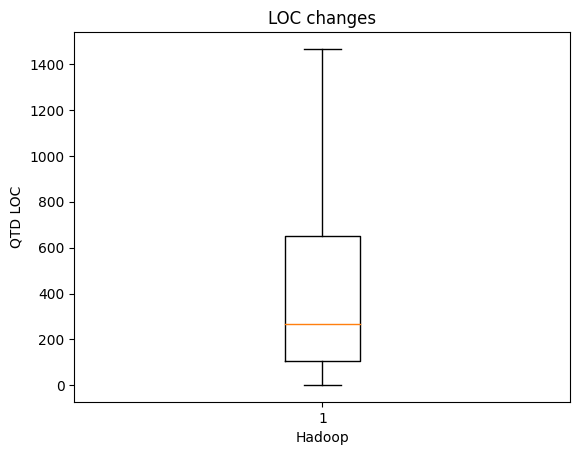

In [55]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('LOC changes')
ax1.set_xlabel('Hadoop')
ax1.set_ylabel('QTD LOC')
ax1.boxplot(x=df_commit_diffs_satd.lines, showfliers=False)

In [57]:
round(df_commit_diffs_satd.lines.describe(), 2)

count      7716.00
mean       1105.88
std        9733.12
min           2.00
25%         107.00
50%         268.00
75%         651.00
max      644212.00
Name: lines, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7e4caf7b3e50>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4cb0a03c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4caf7b2290>],
 'medians': [<matplotlib.lines.Line2D at 0x7e4cb0a01e10>],
 'fliers': [],
 'means': []}

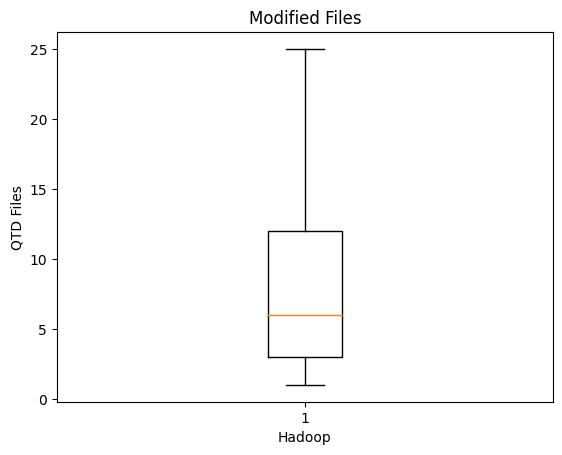

In [56]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('Modified Files')
ax1.set_xlabel('Hadoop')
ax1.set_ylabel('QTD Files')
ax1.boxplot(x=df_commit_diffs_satd.files, showfliers=False)

In [58]:
round(df_commit_diffs_satd.files.describe(), 2)

count    7716.00
mean       12.64
std        61.69
min         1.00
25%         3.00
50%         6.00
75%        12.00
max      3798.00
Name: files, dtype: float64

In [59]:
df_commit_diffs_satd.to_excel('hadoop_diffs_satd.xlsx', index=False)

### Commits with Critical Classes diffs with SATD

In [60]:
print('Conjunto de commits com classes críticas: ')
print(f'{len(set_only_commits_critical_classes)}')

Conjunto de commits com classes críticas: 
2776


In [61]:
df_commits_with_critical_classes_with_satd = df_commit_diffs_satd[df_commit_diffs_satd.commit.isin(set_only_commits_critical_classes)]
df_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
0,5128a9a453d64bfe1ed978cf9ffed27985eeef36,HADOOP-4687 Moving src directories on branch\n...,67543,352,"[files, files, files, files, files, files, int...",[ * Get a checksum of the source files from ...
9,bcd64325a11cb0dd5096ffc093d0ffa68c4fcc58,"Merged src/core, src/test/core, src/contrib/ec...",1799,37,"[files, files, output, support for, fix, TODO,...","[ * <p>Applications specify the files, via url..."
24,280ab0cf7d71882cd3af8cf4e77a1af96844e0c6,HADOOP-6184. Provide an API to dump Configurat...,264,3,"[update, update, output, output, test, test]",[ * Flag to indicate if the storage of resou...
29,e24071be0aec7e63a0b73bf01f4bbd9930ece066,HADOOP-6105. Adds support for automatically ha...,603,4,"[update, update, test, test, test, test]",[ * adds all the deprecations to the depreca...
41,6ef2552953322f086fa63a11385c55b36d124d0b,HADOOP-6233. Rename configuration keys towards...,740,19,[update],[ //TBD: Code is not updated to use following...
...,...,...,...,...,...,...
7649,1d0c9ab4330e87c73e8473bee9c1d4b6db2fd5fd,"Revert ""HADOOP-18207. Introduce hadoop-logging...",2281,120,"[test, TODO, logging, implementation, logging,...",[ * A simple appender for white box testing....
7651,0e6bd09ae3c79d5869ffd9ab6ad579786b1f3cd7,HDFS-17003. Erasure Coding: invalidate wrong b...,166,3,[test],[ * This unit test try to cover the below si...
7684,5b81caf0cf44a532b24387aad2630d92155ce7c4,HDFS-17137. Standby/Observer NameNode skip to ...,59,2,"[redundant, test]",[ * Test Standby/Observer NameNode should no...
7692,10b1d7340b7567849605e283585d6a292a53b127,HDFS-17154. EC: Fix bug in updateBlockForPipel...,29,2,[not used],[ // which is not used in client side. ...


In [62]:
round(df_commits_with_critical_classes_with_satd.describe(), 2)

,lines,files
count,1263.00,1263.00
mean,1609.15,27.69
std,18741.08,146.12
min,7.00,1.00
25%,178.00,6.00
50%,419.00,12.00
75%,917.50,22.00
max,644212.00,3798.00


## Analisa Commits sem SATD

### Analisa todos os diffs (added) dos commits entre 19/05/2009 e 4/10/2023 do Hadoop que SEM as SATD.

In [63]:
dict_commit_diffs_no_satd = my_satd_commit_analyzer.analyze_commit_diffs_for_no_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD diff commit analysis: 100%|██████████| 26906/26906 [25:15<00:00, 17.75it/s]


In [64]:
df_commit_diffs_no_satd = create_df_commits_diffs_no_satd(dict_commit_diffs_no_satd)

In [65]:
df_commit_diffs_no_satd

,commits,msg,lines,files,comments
0,5128a9a453d64bfe1ed978cf9ffed27985eeef36,HADOOP-4687 Moving src directories on branch\n...,67543,352,"[/*, * Licensed to the Apache Software Founda..."
1,c94ff0f240de583311c1bd73cf41d113ade75ebf,HADOOP-4687 More moving around\n\n\ngit-svn-id...,13948,42,[ * quickstart.html is targetted towards fi...
2,abe7be913432053f6d419ea4ca4f9cd2be938bc7,HADOOP-4687 Moving directories around\n\n\ngit...,319738,114,"[/* Copyright (c) 1995-2000, The Hypersonic SQ..."
3,cab0a4bf543f58600ae8499f5b219a452f89c827,HADOOP-4687 split the contrib dirs\n\n\ngit-sv...,29719,243,"[ *), *), *), *), /**, ..."
4,c967cef4d3b82bf05f09ff03ff50243e0a81db26,HADOOP-4687 move more src dirs\n\n\ngit-svn-id...,78824,228,"[/*, * Licensed to the Apache Software Foundat..."
...,...,...,...,...,...
14426,b8815fe68bddd670174b6f1fa19aff178dec7b59,MAPREDUCE-7453. Revert HADOOP-18649. (#6102). ...,310,6,"[ * {@link ContainerLogAppender} or, * ..."
14427,b87180568b261a617dc9645197615efd4c753786,HDFS-17209. Correct comments to align with the...,2,1,"[ // When shutting down for restart, wa..."
14428,a04a9e107b57afb37740ac73ca239d3c335f8695,YARN-11578. Cache fs supports chmod in LogAggr...,149,2,[ //Check if FS has capability to set/modif...
14429,fe3984aa010b7a470bf3dcb00029369435382d1b,YARN-11580. YARN Router Web supports displayin...,579,12,"[ * @param conf Configuration., /**, * ..."


In [66]:
round(df_commit_diffs_no_satd.describe(), 2)

,lines,files
count,14431.00,14431.00
mean,688.31,9.70
std,7213.07,48.65
min,1.00,1.00
25%,59.00,3.00
50%,148.00,5.00
75%,387.00,9.00
max,644212.00,3798.00


In [67]:
df_commit_diffs_no_satd.to_excel('hadoop_commit_diffs_no_satd.xlsx', index=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7e4caef2bdf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4caef28460>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4caeb6ed70>],
 'medians': [<matplotlib.lines.Line2D at 0x7e4caef29480>],
 'fliers': [],
 'means': []}

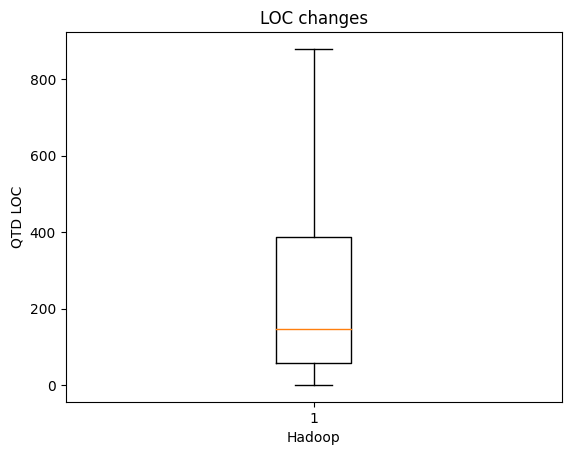

In [68]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('LOC changes')
ax1.set_xlabel('Hadoop')
ax1.set_ylabel('QTD LOC')
ax1.boxplot(x=df_commit_diffs_no_satd.lines, showfliers=False)

In [69]:
round(df_commit_diffs_no_satd.lines.describe(), 2)

count     14431.00
mean        688.31
std        7213.07
min           1.00
25%          59.00
50%         148.00
75%         387.00
max      644212.00
Name: lines, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7e4cac70a380>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4cac709c90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4cac70b490>],
 'medians': [<matplotlib.lines.Line2D at 0x7e4cac70a200>],
 'fliers': [],
 'means': []}

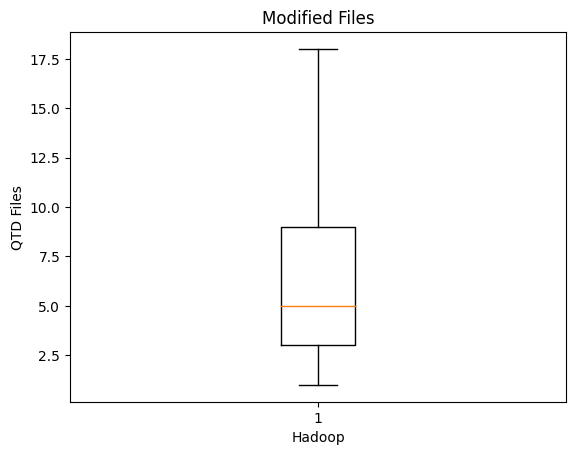

In [70]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('Modified Files')
ax1.set_xlabel('Hadoop')
ax1.set_ylabel('QTD Files')
ax1.boxplot(x=df_commit_diffs_no_satd.files, showfliers=False)

In [71]:
round(df_commit_diffs_no_satd.files.describe(), 2)

count    14431.00
mean         9.70
std         48.65
min          1.00
25%          3.00
50%          5.00
75%          9.00
max       3798.00
Name: files, dtype: float64

In [72]:
df_commits_with_critical_classes_no_satd = df_commit_diffs_no_satd[df_commit_diffs_no_satd.commits.isin(set_only_commits_critical_classes)]
df_commits_with_critical_classes_no_satd

,commits,msg,lines,files,comments
0,5128a9a453d64bfe1ed978cf9ffed27985eeef36,HADOOP-4687 Moving src directories on branch\n...,67543,352,"[/*, * Licensed to the Apache Software Founda..."
9,bcd64325a11cb0dd5096ffc093d0ffa68c4fcc58,"Merged src/core, src/test/core, src/contrib/ec...",1799,37,[ * via the org.apache.hadoop.mapred.JobConf. ...
11,b12d765467fd9a4447c473d613d92883fb09c76b,HADOOP-4687. Merge -r 784663:785643 from trunk...,73,4,[ * sufficient enough to accommodate the file ...
17,a13237975d02b3db913b95845d4b8d6d22f2bac7,HADOOP-2366. Support trimmed strings in Config...,98,4,"[ /**, * Get the comma delimited values of..."
21,3200b2ec588dfa5c50f1ec6192ff93ab9187f82d,HADOOP-6161. Add get/setEnum methods to Config...,43,3,"[ /**, * Set the value of the <code>name</..."
...,...,...,...,...,...
14383,65e4a66e257a7a04ba36a6c3c0cf3139dffaee9f,HDFS-17087. Add Throttler for datanode reading...,160,8,"[ // A value of zero indicates no limit, ..."
14391,b58885624bdbad3a6940a63fc7537fc0beda6784,HDFS-17093. Fix block report lease issue to av...,100,2,"[ /**, * Remove the DN lease only when we ..."
14394,d5334fa76170b99f1ddd6b307482d226da12f1a9,YARN-6537. Running RM tests against the Router...,816,12,"[/**, * Licensed to the Apache Software Found..."
14404,4652d22b9195d35eac4d7e02d1f99ebc6a5835c7,HDFS-17178: BootstrapStandby needs to handle R...,256,11,"[ /**, * Current minimum compatible version..."


In [73]:
round(df_commits_with_critical_classes_no_satd.describe(), 2)

,lines,files
count,2193.00,2193.00
mean,1024.29,21.43
std,14238.30,118.97
min,2.00,1.00
25%,98.00,4.00
50%,256.00,9.00
75%,599.00,18.00
max,644212.00,3798.00


# Comparing Commits with SATD and Commits without SATD

## Geral


### LOC changes

<ipython-input-74-1a1d8acfc0ff>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7e4caef73310>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4caef726b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4caef70d30>,
 'medians': [<matplotlib.lines.Line2D at 0x7e4cadeb0d00>,
 'fliers': [],
 'means': []}

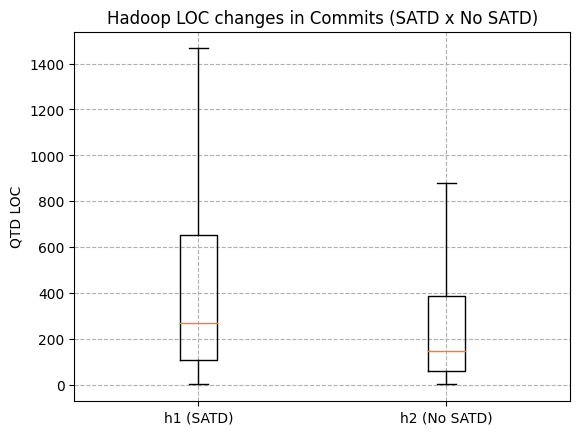

In [74]:
data_lines = [df_commit_diffs_satd.lines, df_commit_diffs_no_satd.lines]
fig1, ax1 = pyplot.subplots()
ax1.set_title('Hadoop LOC changes in Commits (SATD x No SATD)')
ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_lines, showfliers=False)

### Modified Files

<ipython-input-75-e97d9b0ec58b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7e4caebf7130>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4caebf6500>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4caebf4280>,
 'medians': [<matplotlib.lines.Line2D at 0x7e4caebf5420>,
 'fliers': [],
 'means': []}

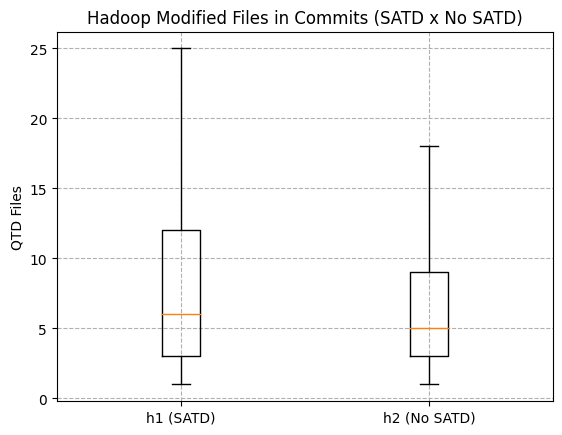

In [75]:
data_files = [df_commit_diffs_satd.files, df_commit_diffs_no_satd.files]
fig1, ax1 = pyplot.subplots()
ax1.set_title('Hadoop Modified Files in Commits (SATD x No SATD)')
ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_files, showfliers=False)

## Commits with Critical Classes

### Geral

**LOC changes**

<ipython-input-76-96e8970d1bfd>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7e4caeed4730>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4caeed4a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4cae1aae30>,
 'medians': [<matplotlib.lines.Line2D at 0x7e4caeed6b90>,
 'fliers': [],
 'means': []}

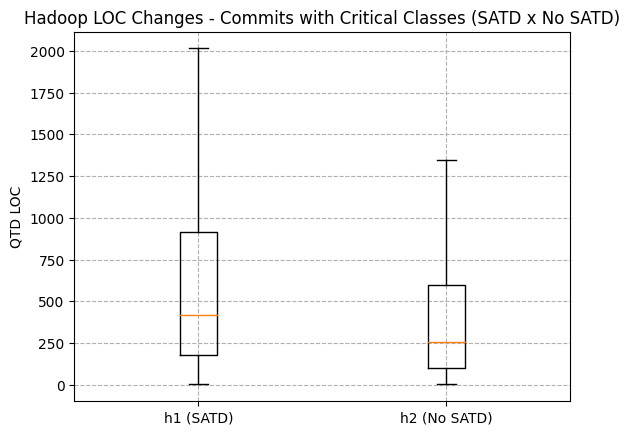

In [76]:
data_commits_cc_lines = df_commits_with_critical_classes_with_satd.lines, df_commits_with_critical_classes_no_satd.lines
fig1, ax1 = pyplot.subplots()
ax1.set_title('Hadoop LOC Changes - Commits with Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_commits_cc_lines, showfliers=False)

**Modified files**

<ipython-input-77-97ebe1c0dc31>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7e4cadefcd60>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4cadefef50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4cadefd960>,
 'medians': [<matplotlib.lines.Line2D at 0x7e4cac20bbb0>,
 'fliers': [],
 'means': []}

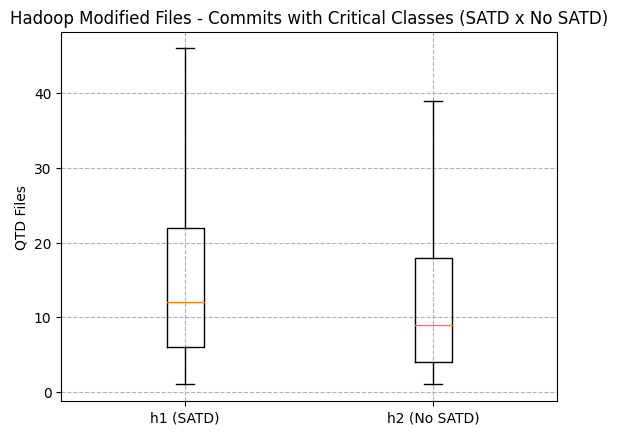

In [77]:
data_commits_cc_files = df_commits_with_critical_classes_with_satd.files, df_commits_with_critical_classes_no_satd.files
fig1, ax1 = pyplot.subplots()
ax1.set_title('Hadoop Modified Files - Commits with Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_commits_cc_files, showfliers=False)

### Issues in commits

In [78]:
df_issues_in_commits_with_critical_classes_with_satd = df_commits_with_critical_classes_with_satd[df_commits_with_critical_classes_with_satd.commit.isin(list_commits_with_critical_classes_with_issues)]
df_issues_in_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
0,5128a9a453d64bfe1ed978cf9ffed27985eeef36,HADOOP-4687 Moving src directories on branch\n...,67543,352,"[files, files, files, files, files, files, int...",[ * Get a checksum of the source files from ...
9,bcd64325a11cb0dd5096ffc093d0ffa68c4fcc58,"Merged src/core, src/test/core, src/contrib/ec...",1799,37,"[files, files, output, support for, fix, TODO,...","[ * <p>Applications specify the files, via url..."
24,280ab0cf7d71882cd3af8cf4e77a1af96844e0c6,HADOOP-6184. Provide an API to dump Configurat...,264,3,"[update, update, output, output, test, test]",[ * Flag to indicate if the storage of resou...
29,e24071be0aec7e63a0b73bf01f4bbd9930ece066,HADOOP-6105. Adds support for automatically ha...,603,4,"[update, update, test, test, test, test]",[ * adds all the deprecations to the depreca...
41,6ef2552953322f086fa63a11385c55b36d124d0b,HADOOP-6233. Rename configuration keys towards...,740,19,[update],[ //TBD: Code is not updated to use following...
...,...,...,...,...,...,...
7389,f6fa5bd1aa085a4d22f3450b545bb70063da9f51,HADOOP-18229. Fix Hadoop-Common JavaDoc Errors...,6196,366,"[debug, exception, exception, exception, outpu...",[ /** For debugging. List non-default proper...
7450,682931a6ace460d829954398eddecefeeac82b34,HADOOP-18028. High performance S3A input strea...,9557,61,"[debug, logging, fix, clean, cleanup, clean, c...",[ * This class is used for debugging/logging. ...
7582,a90238c0b8b767a39b106b7a40f294e5f2bb2410,HADOOP-18631. Migrate Async appenders to log4j...,783,15,"[TODO, logging, implementation, logging, logging]",[ // TODO : hadoop-logging module to hide log...
7647,03a499821c9676da0896ca864074dfb8fbdefd6e,HADOOP-18207. Introduce hadoop-logging module ...,2281,120,"[API, dependencies, logging, clean, cleanup, o...",[ * Hadoop's internal class that access log4j ...


In [79]:
round(df_issues_in_commits_with_critical_classes_with_satd.describe(), 2)

,lines,files
count,84.00,84.00
mean,10378.06,92.76
std,70472.57,428.59
min,7.00,1.00
25%,167.25,3.75
50%,406.00,8.50
75%,1522.00,36.25
max,644212.00,3798.00


In [80]:
df_issues_in_commits_with_critical_classes_no_satd = df_commits_with_critical_classes_no_satd[df_commits_with_critical_classes_no_satd.commits.isin(list_commits_with_critical_classes_with_issues)]
df_issues_in_commits_with_critical_classes_no_satd

,commits,msg,lines,files,comments
0,5128a9a453d64bfe1ed978cf9ffed27985eeef36,HADOOP-4687 Moving src directories on branch\n...,67543,352,"[/*, * Licensed to the Apache Software Founda..."
9,bcd64325a11cb0dd5096ffc093d0ffa68c4fcc58,"Merged src/core, src/test/core, src/contrib/ec...",1799,37,[ * via the org.apache.hadoop.mapred.JobConf. ...
11,b12d765467fd9a4447c473d613d92883fb09c76b,HADOOP-4687. Merge -r 784663:785643 from trunk...,73,4,[ * sufficient enough to accommodate the file ...
17,a13237975d02b3db913b95845d4b8d6d22f2bac7,HADOOP-2366. Support trimmed strings in Config...,98,4,"[ /**, * Get the comma delimited values of..."
21,3200b2ec588dfa5c50f1ec6192ff93ab9187f82d,HADOOP-6161. Add get/setEnum methods to Config...,43,3,"[ /**, * Set the value of the <code>name</..."
...,...,...,...,...,...
14171,90de1ff151ede83a6f963aaf2407d3eb6220ae40,HADOOP-18206 Cleanup the commons-logging refer...,755,71,[ * @deprecated to be removed with 3.4.0. Us...
14186,a90238c0b8b767a39b106b7a40f294e5f2bb2410,HADOOP-18631. Migrate Async appenders to log4j...,783,15,"[ /**, * Deprecated. Use log4j properties ..."
14202,b6a9d7b4429970e332e5e07f0cf3265ee5d0e909,HADOOP-18631. (ADDENDUM) Use LogCapturer to ma...,249,5,[ // dfs.namenode.audit.log.async is no lon...
14296,03a499821c9676da0896ca864074dfb8fbdefd6e,HADOOP-18207. Introduce hadoop-logging module ...,2281,120,"[/*, * Licensed to the Apache Software Founda..."


In [81]:
round(df_issues_in_commits_with_critical_classes_no_satd.describe(), 2)

,lines,files
count,172.00,172.00
mean,5182.90,61.78
std,49363.06,329.60
min,4.00,1.00
25%,54.75,3.00
50%,157.00,5.00
75%,462.25,16.25
max,644212.00,3798.00


**LOC changes**

<ipython-input-82-5be0a39e182d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7e4cade91de0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4cae828ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4cade929b0>,
 'medians': [<matplotlib.lines.Line2D at 0x7e4cade93c40>,
 'fliers': [],
 'means': []}

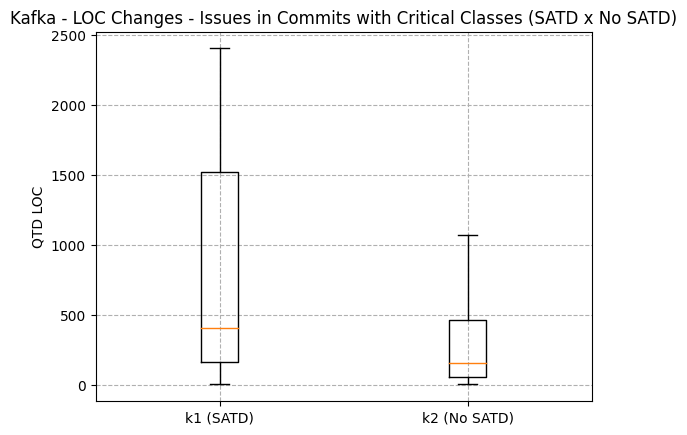

In [82]:
data_issues_commits_cc_lines = df_issues_in_commits_with_critical_classes_with_satd.lines, df_issues_in_commits_with_critical_classes_no_satd.lines
fig1, ax1 = pyplot.subplots()
ax1.set_title('Kafka - LOC Changes - Issues in Commits with Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_issues_commits_cc_lines, showfliers=False)

**Modified Files**

<ipython-input-83-45ccdc67f149>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7e4cadecbca0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4cadec9030>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4cadec8520>,
 'medians': [<matplotlib.lines.Line2D at 0x7e4cadeca9b0>,
 'fliers': [],
 'means': []}

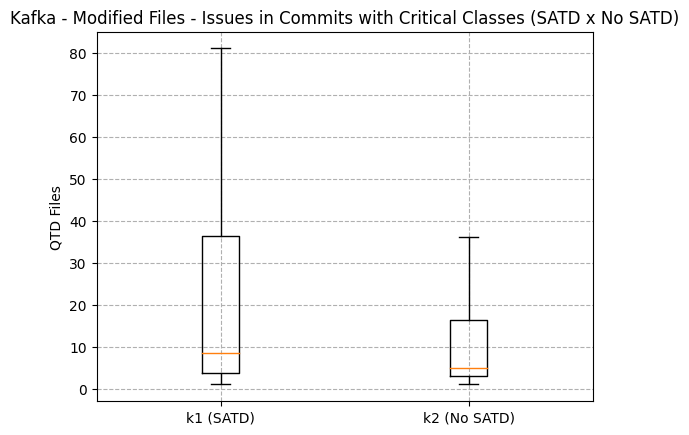

In [83]:
data_issues_commits_cc_files = df_issues_in_commits_with_critical_classes_with_satd.files, df_issues_in_commits_with_critical_classes_no_satd.files
fig1, ax1 = pyplot.subplots()
ax1.set_title('Kafka - Modified Files - Issues in Commits with Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['k1 (SATD)', 'k2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_issues_commits_cc_files, showfliers=False)

## Commits without Critical Classes

In [84]:
print('Commits sem classes críticas: ', len(list_commits_no_critical_classes))

Commits sem classes críticas:  24130


In [85]:
dict_commits_no_critical_classes = {}
for k, v in all_commits.items():
  if k in list_commits_no_critical_classes:
    dict_commits_no_critical_classes[k] = v

print(len(dict_commits_no_critical_classes))

24130


In [86]:
df_commits_no_critical_classes = convert_commits_to_dataframe2(dict_commits_no_critical_classes)
df_commits_no_critical_classes

,hash,msg,date,lines,files,modified_files,diff_modified_files
0,c94ff0f240de583311c1bd73cf41d113ade75ebf,HADOOP-4687 More moving around\n\n\ngit-svn-id...,19/5/2009,13948,42,"[CHANGES.txt, LICENSE.txt, NOTICE.txt, README....","[{'CHANGES.txt': '@@ -0,0 +1,8971 @@ +Hadoop C..."
1,abe7be913432053f6d419ea4ca4f9cd2be938bc7,HADOOP-4687 Moving directories around\n\n\ngit...,19/5/2009,319738,114,"[commons-cli-2.0-SNAPSHOT.jar, hsqldb-1.8.0.10...",[{'commons-cli-2.0-SNAPSHOT.jar': 'Binary file...
2,cab0a4bf543f58600ae8499f5b219a452f89c827,HADOOP-4687 split the contrib dirs\n\n\ngit-sv...,19/5/2009,29719,243,"[README, hadoop.sh, build-contrib.xml, build.x...","[{'README': '@@ -0,0 +1,11 @@ +Bash tab comple..."
3,c967cef4d3b82bf05f09ff03ff50243e0a81db26,HADOOP-4687 move more src dirs\n\n\ngit-svn-id...,19/5/2009,78824,228,"[ChangesFancyStyle.css, ChangesSimpleStyle.css...","[{'ChangesFancyStyle.css': '@@ -0,0 +1,170 @@ ..."
4,95a0db602b2e0606af11d666d9d10d64766f9ecf,HADOOP-4687. move test dirs\n\n\ngit-svn-id: h...,19/5/2009,7550,36,"[saveVersion.sh, test-patch.sh, checkstyle-nof...","[{'saveVersion.sh': '@@ -0,0 +1,59 @@ +#!/bin/..."
...,...,...,...,...,...,...,...
24125,5f47f091a227ecd1d9b1b375e9c71e01d31a264f,YARN-11537. [Addendum][Federation] Router CLI ...,29/9/2023,102,2,"[FederationRMAdminInterceptor.java, TestFedera...",[{'FederationRMAdminInterceptor.java': '@@ -13...
24126,b8815fe68bddd670174b6f1fa19aff178dec7b59,MAPREDUCE-7453. Revert HADOOP-18649. (#6102). ...,1/10/2023,310,6,"[MRApps.java, mapred-default.xml, ContainerLog...","[{'MRApps.java': '@@ -60,6 +60,8 @@ import or..."
24127,a04a9e107b57afb37740ac73ca239d3c335f8695,YARN-11578. Cache fs supports chmod in LogAggr...,2/10/2023,149,2,"[LogAggregationFileController.java, TestLogAgg...",[{'LogAggregationFileController.java': '@@ -33...
24128,fe3984aa010b7a470bf3dcb00029369435382d1b,YARN-11580. YARN Router Web supports displayin...,3/10/2023,579,12,"[SubClusterInfo.java, RouterServerUtil.java, A...","[{'SubClusterInfo.java': '@@ -76,6 +76,13 @@ p..."


In [87]:
round(df_commits_no_critical_classes.describe(), 2)

,lines,files
count,24130.00,24130.00
mean,505.30,7.74
std,4611.07,52.08
min,0.00,0.00
25%,10.00,2.00
50%,46.00,3.00
75%,181.00,5.00
max,319738.00,4868.00


In [88]:
list_commits_no_critical_classes = df_commits_no_critical_classes.hash.to_list()
print(len(list_commits_no_critical_classes))

24130


### Commits sem critical classes com SATD

In [89]:
df_commits_without_critical_classes_with_satd = df_commit_diffs_satd[df_commit_diffs_satd.commit.isin(list_commits_no_critical_classes)]
df_commits_without_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
1,c94ff0f240de583311c1bd73cf41d113ade75ebf,HADOOP-4687 More moving around\n\n\ngit-svn-id...,13948,42,[documentation],[ * the documentation and/or other material...
2,abe7be913432053f6d419ea4ca4f9cd2be938bc7,HADOOP-4687 Moving directories around\n\n\ngit...,319738,114,"[documentation, documentation, files, files, u...",[ * this list of conditions and the following ...
3,cab0a4bf543f58600ae8499f5b219a452f89c827,HADOOP-4687 split the contrib dirs\n\n\ngit-sv...,29719,243,"[constructor, files, test, TODO, TODO, TODO, T...",[ * Image library constructor: put image def...
4,c967cef4d3b82bf05f09ff03ff50243e0a81db26,HADOOP-4687 move more src dirs\n\n\ngit-svn-id...,78824,228,"[fix, header, clean, leak, leak, performance, ...","[ //fix IE bug, * header. See Mozilla ..."
5,95a0db602b2e0606af11d666d9d10d64766f9ecf,HADOOP-4687. move test dirs\n\n\ngit-svn-id: h...,7550,36,"[comment, test, fix, test, files, test, test, ...",[ * comment...
...,...,...,...,...,...,...
7711,3de66f5c4046cf9e44c1f6b14779bc4f6442e92f,YARN-11547. [Federation] Router Supports Remov...,173,2,"[TODO, design, test]",[ // TODO: YARN-11548. [Federation] Router ...
7712,1d2afc5cf6f816461b76ec2bdbab8209052cd129,YARN-8862. [BackPort] [GPG] Add Yarn Registry ...,191,8,[clean],[ // The known app should not be cleaned in...
7713,5f47f091a227ecd1d9b1b375e9c71e01d31a264f,YARN-11537. [Addendum][Federation] Router CLI ...,102,2,"[exception, exception, design, test, design, t...",[ * @throws YarnException indicates exceptio...
7714,fe3984aa010b7a470bf3dcb00029369435382d1b,YARN-11580. YARN Router Web supports displayin...,579,12,[interface],[ // Call the RM interface to obtain sc...


In [90]:
round(df_commits_without_critical_classes_with_satd.describe(), 2)

,lines,files
count,6453.00,6453.00
mean,1007.37,9.70
std,6672.27,17.92
min,2.00,1.00
25%,98.00,3.00
50%,240.00,5.00
75%,592.00,11.00
max,319738.00,461.00


### Commits sem critical classes e sem SATD

In [91]:
df_commits_without_critical_classes_no_satd = df_commit_diffs_no_satd[df_commit_diffs_no_satd.commits.isin(list_commits_no_critical_classes)]
df_commits_without_critical_classes_no_satd

,commits,msg,lines,files,comments
1,c94ff0f240de583311c1bd73cf41d113ade75ebf,HADOOP-4687 More moving around\n\n\ngit-svn-id...,13948,42,[ * quickstart.html is targetted towards fi...
2,abe7be913432053f6d419ea4ca4f9cd2be938bc7,HADOOP-4687 Moving directories around\n\n\ngit...,319738,114,"[/* Copyright (c) 1995-2000, The Hypersonic SQ..."
3,cab0a4bf543f58600ae8499f5b219a452f89c827,HADOOP-4687 split the contrib dirs\n\n\ngit-sv...,29719,243,"[ *), *), *), *), /**, ..."
4,c967cef4d3b82bf05f09ff03ff50243e0a81db26,HADOOP-4687 move more src dirs\n\n\ngit-svn-id...,78824,228,"[/*, * Licensed to the Apache Software Foundat..."
5,95a0db602b2e0606af11d666d9d10d64766f9ecf,HADOOP-4687. move test dirs\n\n\ngit-svn-id: h...,7550,36,"[/*, * Generated by src/saveVersion.sh, */, ..."
...,...,...,...,...,...
14425,5f47f091a227ecd1d9b1b375e9c71e01d31a264f,YARN-11537. [Addendum][Federation] Router CLI ...,102,2,[ // If we don't have any filtering cri...
14426,b8815fe68bddd670174b6f1fa19aff178dec7b59,MAPREDUCE-7453. Revert HADOOP-18649. (#6102). ...,310,6,"[ * {@link ContainerLogAppender} or, * ..."
14428,a04a9e107b57afb37740ac73ca239d3c335f8695,YARN-11578. Cache fs supports chmod in LogAggr...,149,2,[ //Check if FS has capability to set/modif...
14429,fe3984aa010b7a470bf3dcb00029369435382d1b,YARN-11580. YARN Router Web supports displayin...,579,12,"[ * @param conf Configuration., /**, * ..."


In [92]:
round(df_commits_without_critical_classes_no_satd.describe(), 2)

,lines,files
count,12238.00,12238.00
mean,628.11,7.59
std,5001.39,15.06
min,1.00,1.00
25%,54.00,2.00
50%,134.00,4.00
75%,353.00,8.00
max,319738.00,461.00


### Testes dos commits sem critical classes

**LOC changes**

<ipython-input-93-c40430dbec78>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7e4caeb3ab60>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4caeb38f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4caeb3a800>,
 'medians': [<matplotlib.lines.Line2D at 0x7e4caf0df1c0>,
 'fliers': [],
 'means': []}

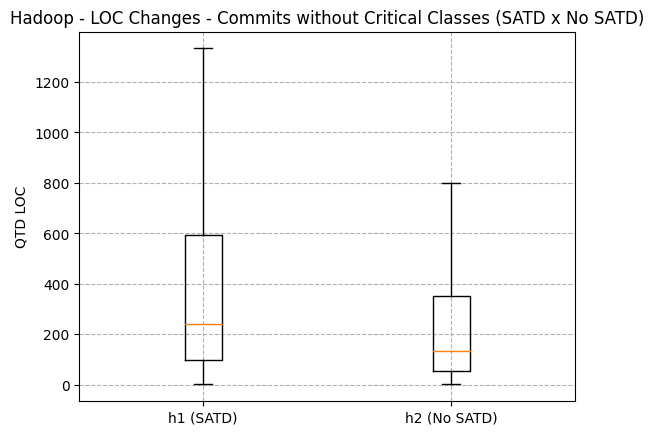

In [93]:
data_commits_no_cc_lines = df_commits_without_critical_classes_with_satd.lines, df_commits_without_critical_classes_no_satd.lines

fig1, ax1 = pyplot.subplots()

ax1.set_title('Hadoop - LOC Changes - Commits without Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_no_cc_lines, showfliers=False)

**Modified Files**

<ipython-input-94-93602b23ca38>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7e4cae8c1f30>,
 'caps': [<matplotlib.lines.Line2D at 0x7e4cae8c20e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e4cade58ee0>,
 'medians': [<matplotlib.lines.Line2D at 0x7e4cade59c60>,
 'fliers': [],
 'means': []}

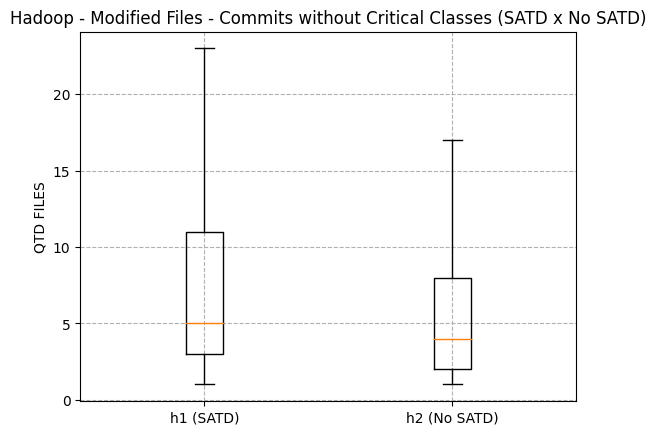

In [94]:
data_commits_no_cc_files = df_commits_without_critical_classes_with_satd.files, df_commits_without_critical_classes_no_satd.files

fig1, ax1 = pyplot.subplots()

ax1.set_title('Hadoop - Modified Files - Commits without Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['h1 (SATD)', 'h2 (No SATD)'])
ax1.set_ylabel('QTD FILES')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_no_cc_files, showfliers=False)